# View GCaMP mismatch regular and closed loop data

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.stats import pearsonr, spearmanr
from analysis_functions import *
from model_functions import *
import matplotlib.patches as patches
import seaborn as sns

In [38]:
RunTresholdDict = {'B3M1': 145, 'B3M2': 295, 'B3M3': 325, 'B2M4': 110, 'B2M5': 180}

In [39]:
GCaMP_Reg_1 = pd.read_csv('GCaMP_MMclosed_regular_session1.csv', dtype=dtype_dict)
GCaMP_Reg_2 = pd.read_csv('GCaMP_MMclosed_regular_session2.csv', dtype=dtype_dict)

In [42]:
#Make sure the index provides inforamtion of seconds since start
GCaMP_Reg_1.set_index('Seconds', inplace=True)
GCaMP_Reg_2.set_index('Seconds', inplace=True)

In [43]:
#Have a look that the data is as expected
GCaMP_Reg_1

470_dfF     movementX  movementY  event ExperimentEvents  \
Seconds                                                               
0.000    -0.000021  1.411287e-03   0.000578  False              NaN   
0.001    -0.000067  4.547482e-03   0.001861  False              NaN   
0.002    -0.000113  6.272389e-03   0.002336  False              NaN   
0.003    -0.000159  6.272389e-03   0.001823  False              NaN   
0.004    -0.000205  6.272389e-03   0.001309  False              NaN   
...            ...           ...        ...    ...              ...   
1992.723  5.189932  1.729690e-05   0.000000  False              NaN   
1992.724  5.186361  1.255802e-05   0.000000  False              NaN   
1992.725  5.182791  7.819145e-06   0.000000  False              NaN   
1992.726  5.179220  3.080269e-06   0.000000  False              NaN   
1992.727  5.177078  2.369438e-07   0.000000  False              NaN   

                    Experiment Session mouseID sex area  No_halt  \
Seconds                                                            
0.000     MMclosed-and-Regular    day1    B2M4   M  V2M    False   
0.001     MMclosed-and-Regular    day1    B2M4   M  V2M    False   
0.002     MMclosed-and-Regular    day1    B2M4   M  V2M    False   
0.003     MMclosed-and-Regular    day1    B2M4   M  V2M    False   
0.004     MMclosed-and-Regular    day1    B2M4   M  V2M    False   
...                        ...     ...     ...  ..  ...      ...   
1992.723  MMclosed-and-Regular    day1    B3M3   F   V1    False   
1992.724  MMclosed-and-Regular    day1    B3M3   F   V1    False   
1992.725  MMclosed-and-Regular    day1    B3M3   F   V1    False   
1992.726  MMclosed-and-Regular    day1    B3M3   F   V1    False   
1992.727  MMclosed-and-Regular    day1    B3M3   F   V1    False   

          LinearMismatch_block  LinearRegularMismatch_block  \
Seconds                                                       
0.000                    False                        False   
0.001                    False                        False   
0.002                    False                        False   
0.003                    False                        False   
0.004                    False                        False   
...                        ...                          ...   
1992.723                 False                        False   
1992.724                 False                        False   
1992.725                 False                        False   
1992.726                 False                        False   
1992.727                 False                        False   

          LinearNormal_block  
Seconds                       
0.000                  False  
0.001                  False  
0.002                  False  
0.003                  False  
0.004                  False  
...                      ...  
1992.723               False  
1992.724               False  
1992.725               False  
1992.726               False  
1992.727               False  

[9861055 rows x 14 columns]

In [44]:
# Chaning event name to halt and making it so that its True when there is a halt
#GCaMP_Reg_1.loc[:, 'event'] = GCaMP_Reg_1['event'].replace({False: True, True: False})
GCaMP_Reg_1.rename(columns = {'event': 'halt'}, inplace = True)
GCaMP_Reg_2.rename(columns = {'event': 'halt'}, inplace = True)

In [45]:
#Check that the same mice are in the datsets
print(GCaMP_Reg_1.mouseID.unique())
print(GCaMP_Reg_2.mouseID.unique())


['B2M4' 'B2M5' 'B3M1' 'B3M2' 'B3M3']
['B2M4' 'B2M5' 'B3M1' 'B3M2']


def view_session_mouse(mousedata_dict, mouse):
    print('\033[1m' + f'Plotted traces for {mouse}' + '\033[0m')
    
    plotlist = ['470_dfF', 'movementX']
    fig, ax = plt.subplots(len(plotlist), len(mousedata_dict), figsize=(15, 10), sharex=True)  # sharex=True for a shared x-axis
    
    for s, (session, session_data) in enumerate(mousedata_dict.items()):
        
        # Getting the mouse-specific data from the session
        time = session_data.index
        event = session_data.halt
        color = ['forestgreen', 'blue']
    
        # Iterate over the traces in plotlist and plot each on a new row
        for i, trace in enumerate(plotlist):
            ax[i, s].plot(time, session_data[trace], color=color[i])
            ax[i, s].set_title(f"{trace} - {session}")
            
            # Plot shaded areas for each halt event
            ymin, ymax = ax[i, s].get_ylim()
            halt = ax[i, s].fill_between(time, ymin, ymax, where=event, color='grey', alpha=0.3)
        
        # Plot annotations for different blocks
        block_colors = ['lightsteelblue', 'lightcoral', 'forestgreen']
        colorcount = 0
        for col in session_data:
            if '_block' in col:
                start = session_data.loc[session_data[col] == True].index[0]
                end = session_data.loc[session_data[col] == True].index[-1]
        
                min_time, max_time = ax[0, s].get_xlim()
                norm_start = norm(start, min_time, max_time)
                norm_end = norm(end, min_time, max_time)
                
                # Add rectangles with alpha=0.1 to each trace subplot in this session
                for i in range(len(plotlist)):
                    ax[i, s].add_patch(Rectangle(
                        (norm_start, 0), norm_end - norm_start, 1, 
                        facecolor=block_colors[colorcount], alpha=0.1, clip_regn=False, transform=ax[i, s].transAxes
                    ))

                # Add labels at the bottom of the last plot
                ax[-1, s].text(norm_start + 0.05, -0.2, col, transform=ax[-1, s].transAxes,
                               fontsize=10, verticalalignment='top')
                ax[-1, s].add_patch(Rectangle(
                    (norm_start, -0.15), norm_end - norm_start, -0.2, 
                    facecolor=block_colors[colorcount], alpha=0.5, clip_regn=False, transform=ax[-1, s].transAxes))
                
                colorcount += 1

    halt.set_label('halts')
    # Create one legend for the figure
    fig.legend(fontsize=12)
    
    # Update font size and layout
    plt.rcParams.update({'font.size': 10})
    fig.tight_layout(pad=1.08)
    plt.show()
    try:
        return fig, ax
    except TypeError:
        fig, ax = plt.subplots(len(plotlist), len(mousedata_dict))
        return fig, ax

Plotted traces for B2M4


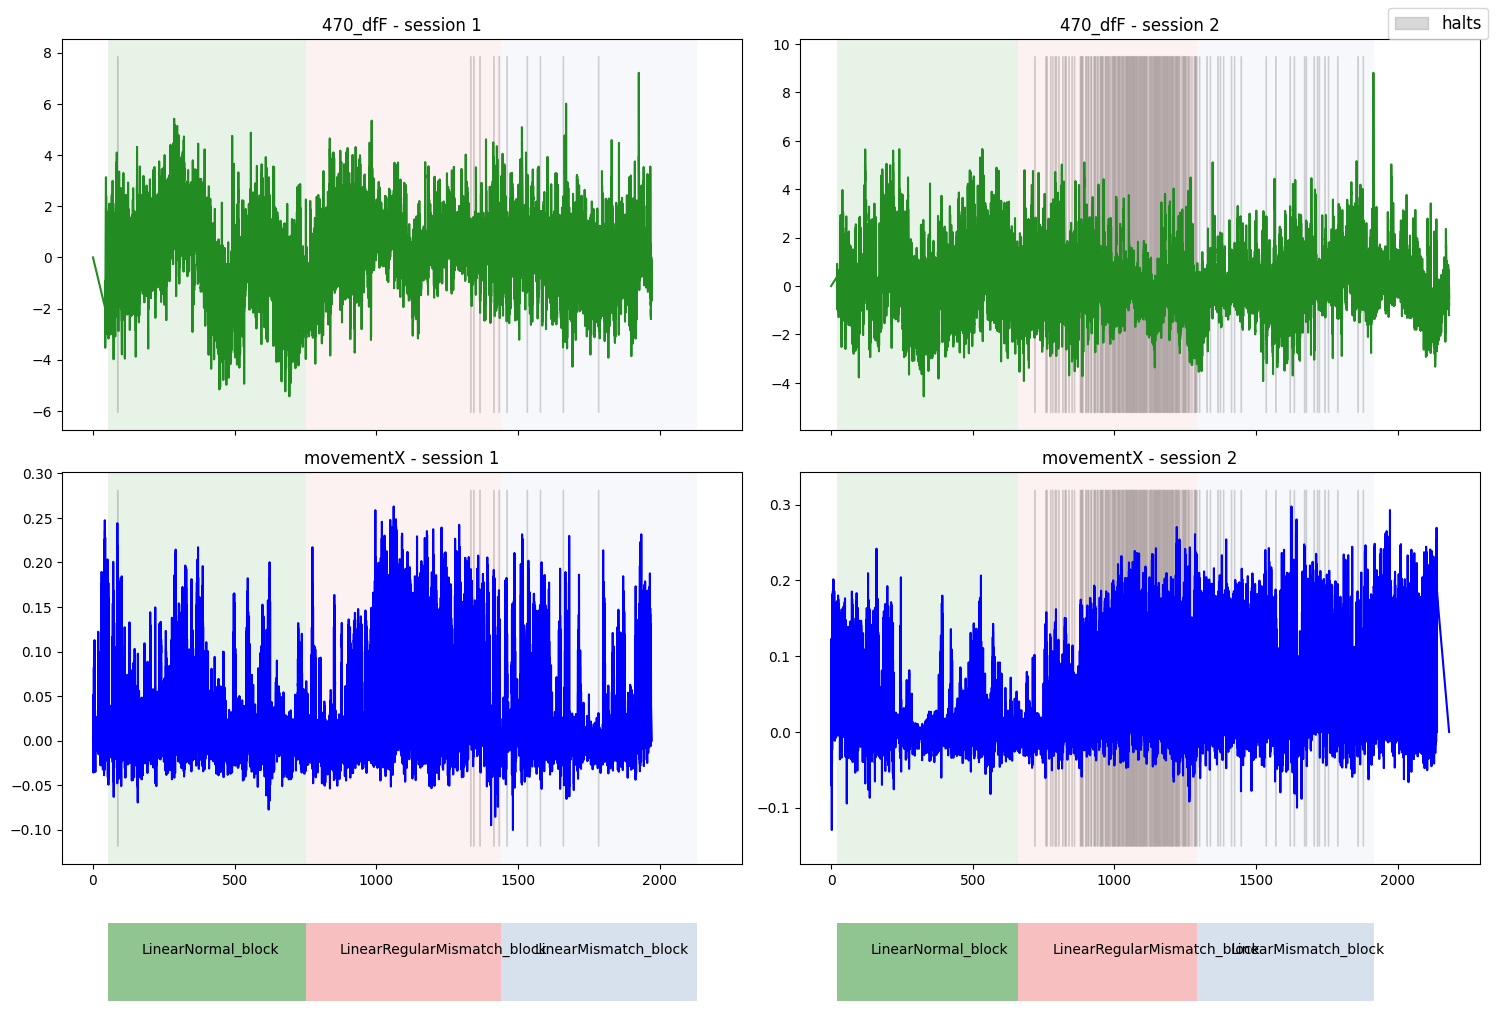

Plotted traces for B2M5


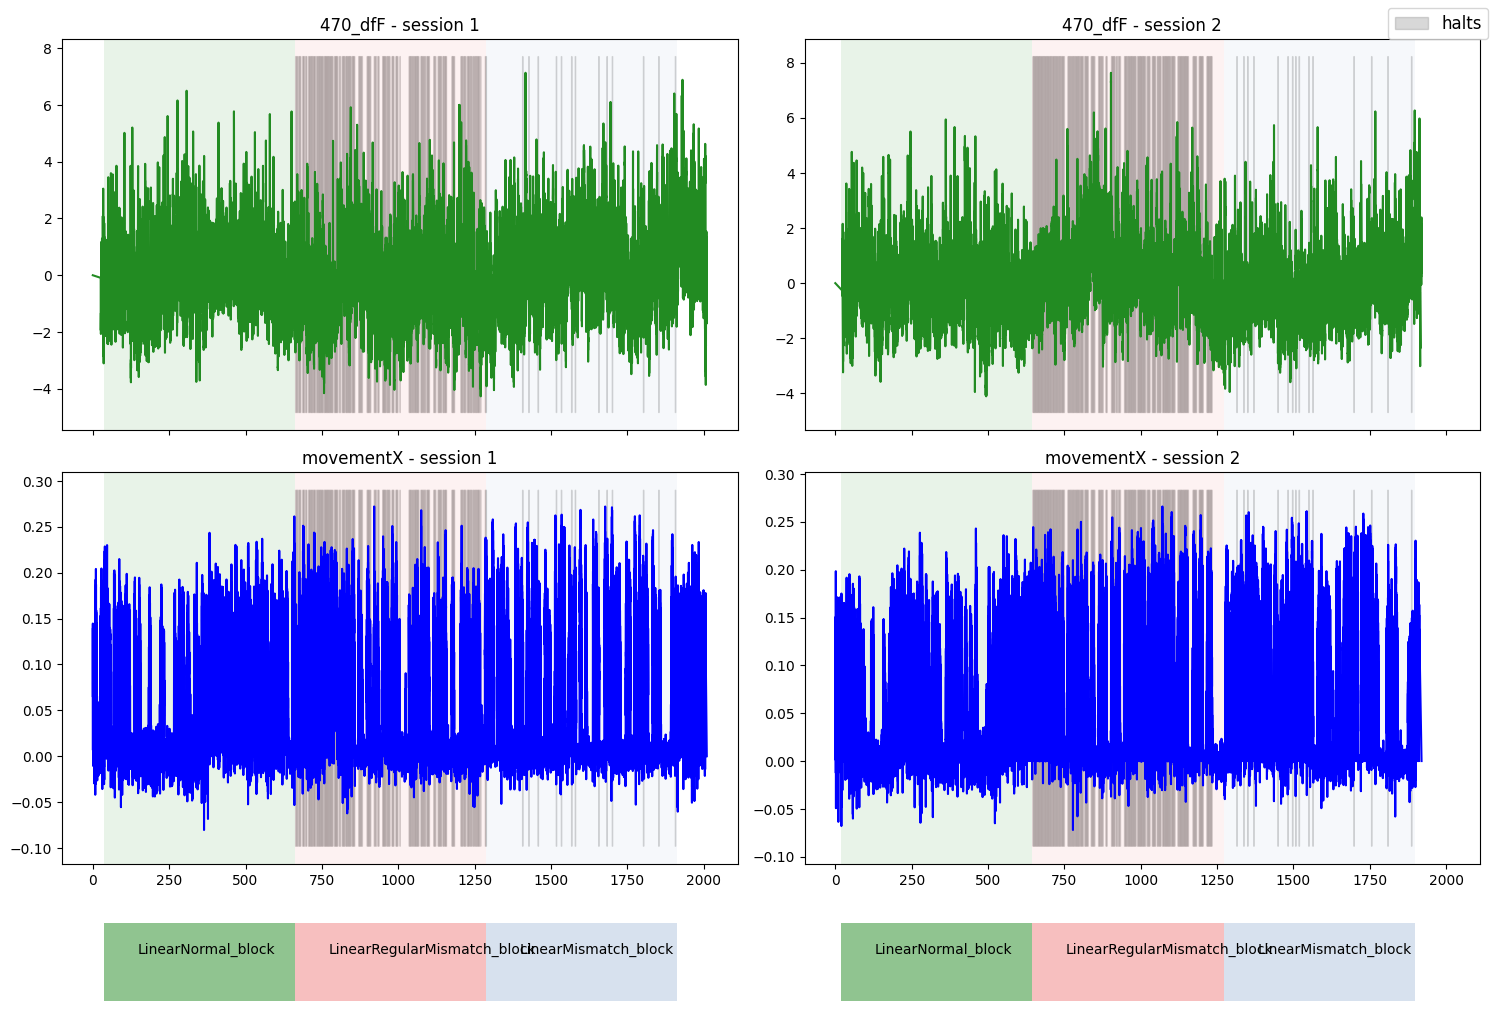

Plotted traces for B3M1


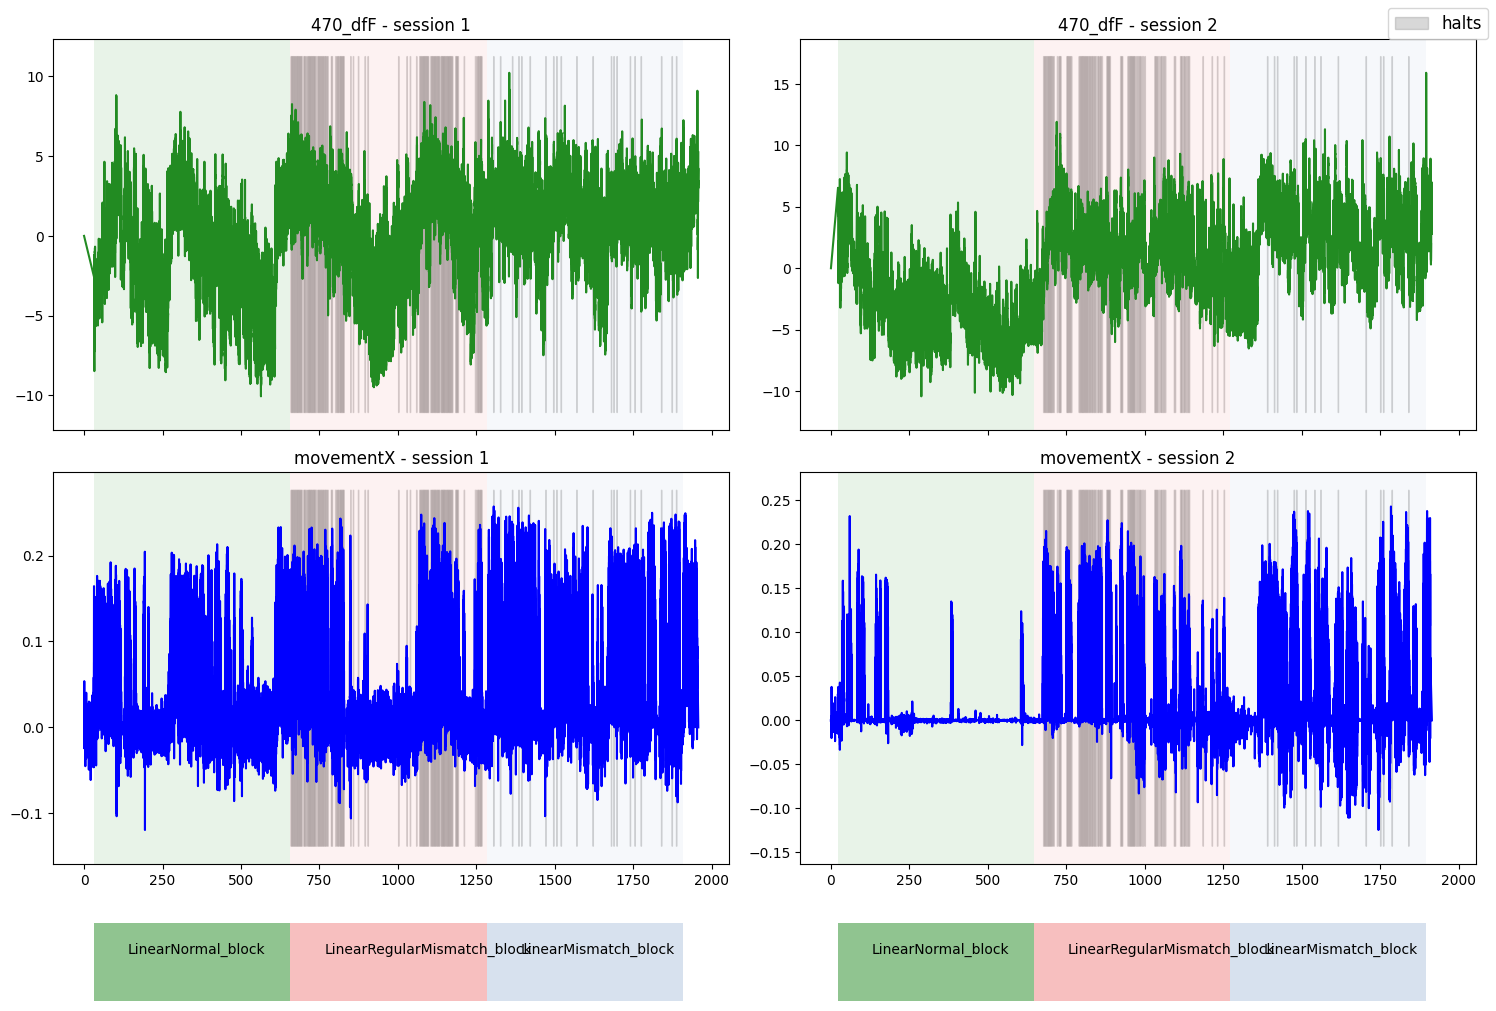

Plotted traces for B3M2


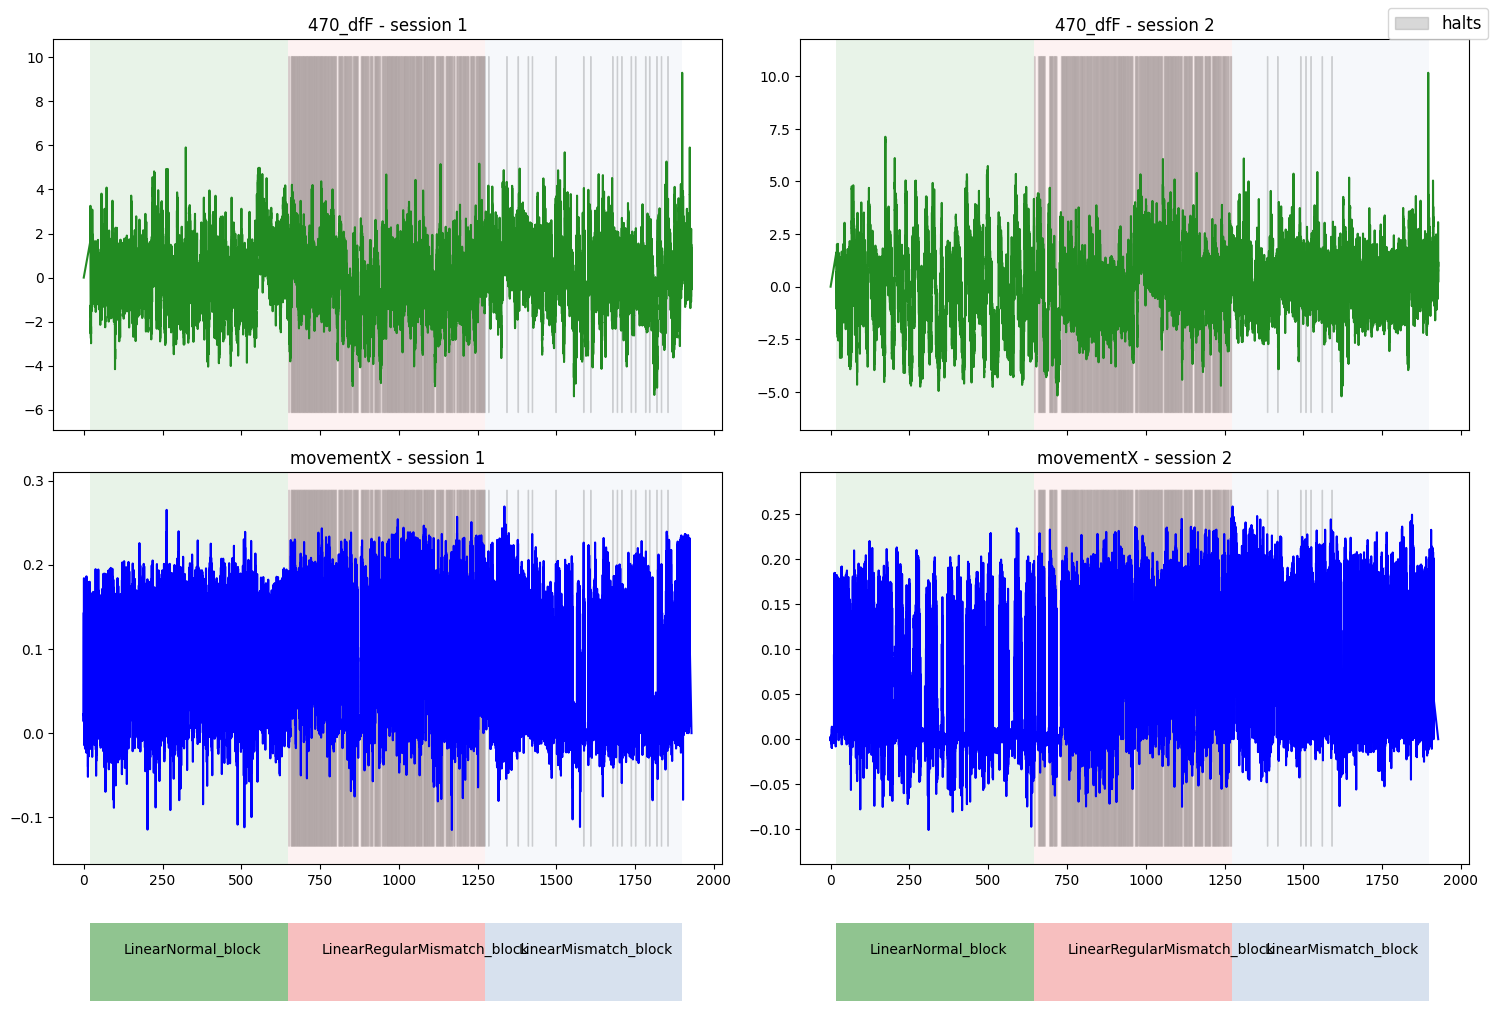

Plotted traces for B3M3
No data for B3M3 session session 2


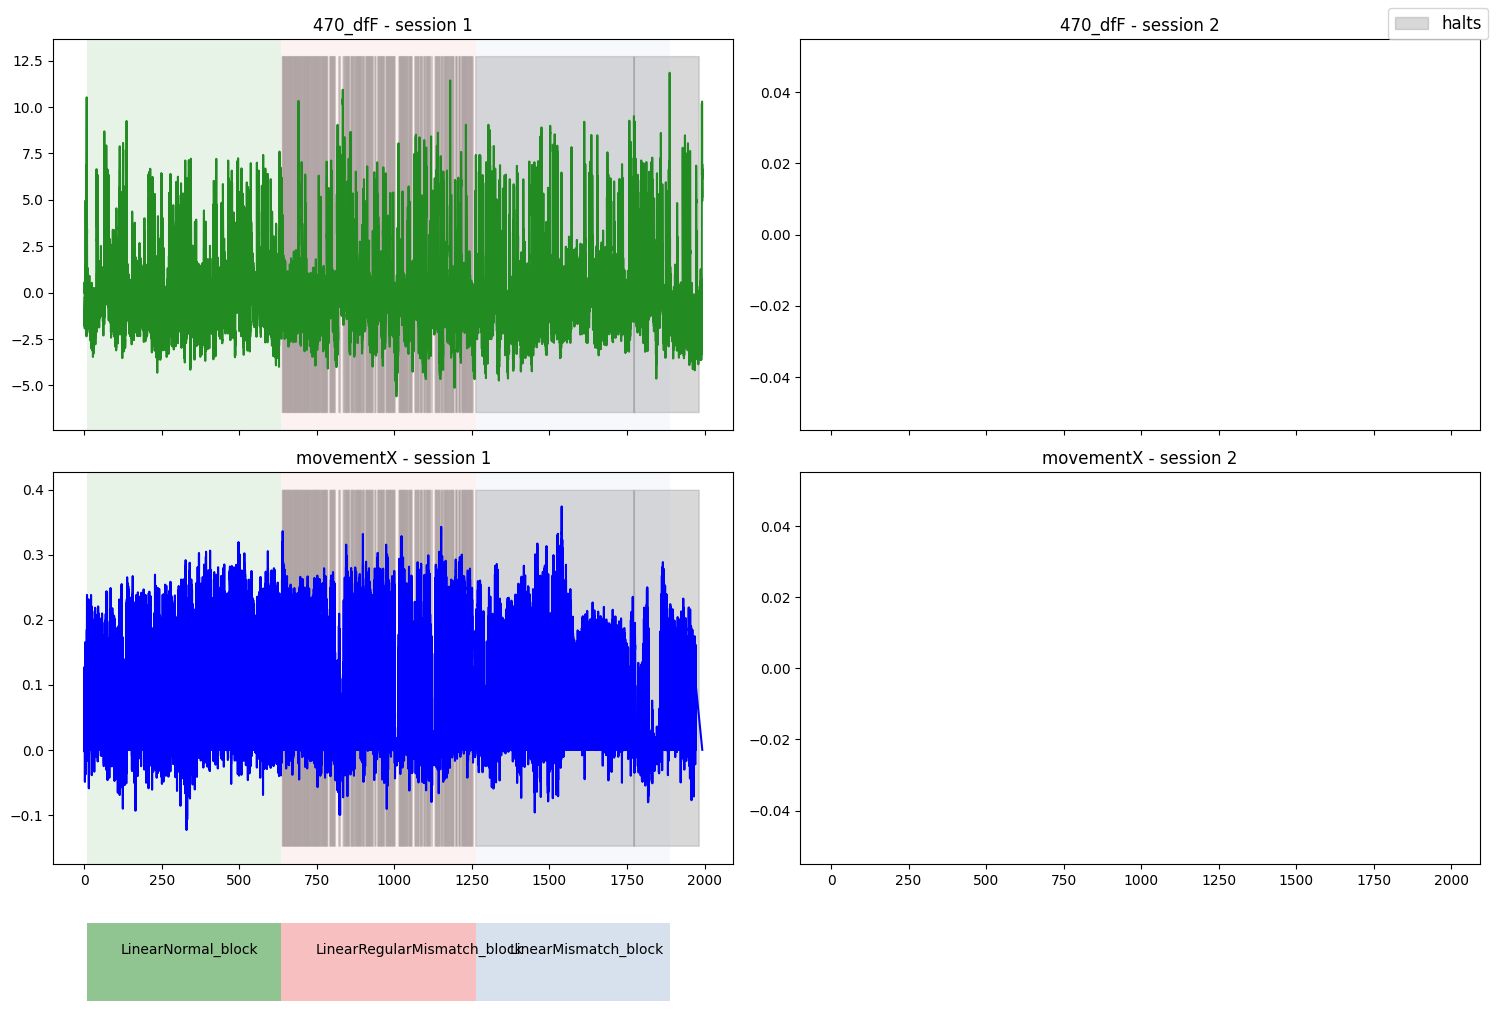

In [46]:
for mouse in GCaMP_Reg_1.mouseID.unique():
    mousedata = {'session 1':GCaMP_Reg_1.loc[GCaMP_Reg_1.mouseID == mouse], 'session 2':GCaMP_Reg_2.loc[GCaMP_Reg_2.mouseID == mouse]}
    fig, ax = view_session_mouse(mousedata, mouse)
    fig.savefig(f'Figures/GRAB{mouse}_view_alignment.png', format = 'png', dpi = 300)

## Filter with respect to blocks
Use the function: filter_data(data, filters = []). 
Ensure that therere is a filter in the filterdict within the function that corresponds to the blocks and other column specified values that you want to filter by.

You can add filters by adding lines to the dict of this format:
    'filter key name': ['Relevant column name', Relevant row values to filter],

Add the same filters to the dict you define below

In [47]:
#Filter mice to get unique indexes

# first make the dict structure
mouse_data = {'session 1':{'closedloop': {},'regular': {}, 'no_mismatch':{}}, 'session 2': {'closedloop': {},'regular': {}, 'no_mismatch':{}}}

#Then assign mouse by mouse with filtered data to the dict
for mouse in GCaMP_Reg_1.mouseID.unique():
    mouse_data['session 1']['closedloop'][mouse] = filter_data(GCaMP_Reg_1, filters = [mouse, 'closed_block'])
    mouse_data['session 1']['regular'][mouse] = filter_data(GCaMP_Reg_1, filters = [mouse, 'regular_block'])
    mouse_data['session 1']['no_mismatch'][mouse] = filter_data(GCaMP_Reg_1, filters = [mouse, 'normal_block'])
    
for mouse in GCaMP_Reg_2.mouseID.unique():
    mouse_data['session 2']['closedloop'][mouse] = filter_data(GCaMP_Reg_1, filters = [mouse, 'closed_block'])
    mouse_data['session 2']['regular'][mouse] = filter_data(GCaMP_Reg_1, filters = [mouse, 'regular_block'])
    mouse_data['session 2']['no_mismatch'][mouse] = filter_data(GCaMP_Reg_1, filters = [mouse, 'normal_block'])

In [48]:
mouse_data 

{'session 1': {'closedloop': {'B2M4':            470_dfF  movementX  movementY   halt              ExperimentEvents  \
   Seconds                                                                         
   1302.652 -0.491789   0.088606  -0.002220  False  LinearMismatch block started   
   1302.653 -0.497852   0.093356  -0.001450  False                           NaN   
   1302.654 -0.503915   0.098105  -0.000680  False                           NaN   
   1302.655 -0.509978   0.102854   0.000090  False                           NaN   
   1302.656 -0.516040   0.107603   0.000860  False                           NaN   
   ...            ...        ...        ...    ...                           ...   
   1929.158 -0.574961   0.007935   0.001656  False                           NaN   
   1929.159 -0.583666   0.007845   0.001912  False                           NaN   
   1929.160 -0.592371   0.007755   0.002169  False                           NaN   
   1929.161 -0.601076   0.007666   0.0024

In [114]:
def align_to_event_start(df, trace, event_col, range_around_event):
    """
    Align trace data around events with improved handling for trace chunks.
    """
    trace_chunk_list = []
    bsl_trace_chunk_list = []
    run_speed_list = []
    turn_speed_list = []
    event_index_list = []
    
    # Identify the start times for each event
    event_times = df.loc[df[event_col] & ~df[event_col].shift(1, fill_value=False)].index

    # Calculate the time range around each event
    before_0 = range_around_event[0]
    after_0 = range_around_event[1]
    
    # Calculate the target length of each chunk based on the sampling rate
    sampling_rate = 0.001
    target_length = int(((before_0 + after_0) / sampling_rate) + 1)  # Include both ends
    Index = pd.Series(np.linspace(-range_around_event[0], range_around_event[1], target_length))  # common index
 
    for event_time in event_times:
        # Determine the time range for each chunk
        start = event_time - before_0
        end = event_time + after_0
  
        # Extract the chunk from the trace column
        chunk = df[trace].loc[start:end]
        runspeed = df['movementX'].loc[start:event_time].mean()  # Saving mean run speed up until halt
        turningspeed = df['movementY'].loc[start:event_time].mean()
        
        # Normalize the index to start at -before_0
        chunk.index = (chunk.index - chunk.index[0]) - before_0
        
        # Check if the chunk is shorter than the target length
        if len(chunk) < target_length:
            # Pad the chunk with NaN values at the end to reach the target length
            padding = pd.Series([np.nan] * (target_length - len(chunk)), index=pd.RangeIndex(len(chunk), target_length))
            chunk = pd.concat([chunk, padding])
            chunk.index = Index  # Getting the same index as the others
    
        # Baseline the chunk
        baselined_chunk = baseline(chunk)
        
        # Append the chunk and baselined chunk to lists
        trace_chunk_list.append(chunk.values)
        bsl_trace_chunk_list.append(baselined_chunk.values)
        run_speed_list.append(runspeed)
        turn_speed_list.append(turningspeed)
        event_index_list.append(event_time)  # Store the event time for use in final column names
    
    if len(event_times) < 1:
        # Return empty DataFrames when there are no events
        trace_chunks = pd.DataFrame()
        bsl_trace_chunks = pd.DataFrame()
        movement_speeds = pd.DataFrame()
    else:
        # Convert lists of arrays to DataFrames
        trace_chunks = pd.DataFrame(np.column_stack(trace_chunk_list), columns=event_index_list)
        bsl_trace_chunks = pd.DataFrame(np.column_stack(bsl_trace_chunk_list), columns=event_index_list)
        run_speeds = pd.DataFrame(np.column_stack(run_speed_list), columns=event_index_list)
        turn_speeds = pd.DataFrame(np.column_stack(turn_speed_list), columns=event_index_list)
        movement_speeds = pd.concat([run_speeds, turn_speeds])
        
        # Set the index as the common time range index for each chunk
        trace_chunks.index = Index
        bsl_trace_chunks.index = Index
        movement_speeds.index = ['Mean_moveX', 'Mean_moveY']  # Set X and Y movement as movement speed index
        
    return trace_chunks, bsl_trace_chunks, movement_speeds


In [115]:
#Aligning no_mismatch, regular and closed loop block data to halt start times
mouse_aligned = {'session 1':{'closedloop': {},'regular': {}, 'no_mismatch':{}}, 'session 2': {'closedloop': {},'regular': {}, 'no_mismatch':{}}}
move_speeds = {'session 1':{'closedloop': {},'regular': {}, 'no_mismatch':{}}, 'session 2': {'closedloop': {},'regular': {}, 'no_mismatch':{}}}

for session, session_dict in mouse_data.items():
    for block, mice in session_dict.items():
        for mouse, df in mice.items():
            event_alinged, bsl_event_alinged, run_speeds = align_to_event_start(df, '470_dfF', 'halt',[1,2])
            mouse_aligned[session][block][mouse]  = bsl_event_alinged  #bsl indicates that it is baselined to the last 1 second before halt
            move_speeds[session][block][mouse]  = run_speeds
    

In [116]:
#have a look at some random mouse data
mouse_aligned['session 1']['closedloop']['B3M1']

1304.776  1326.526  1364.692  1384.942  1393.992  1420.959  1470.975  \
-1.000  0.356823  0.778941 -0.068535  0.709551 -0.193068  0.878699  0.356360   
-0.999  0.364400  0.735061 -0.068851  0.735255 -0.201592  0.887433  0.362305   
-0.998  0.371976  0.691181 -0.069167  0.760958 -0.210115  0.896167  0.368250   
-0.997  0.379552  0.647301 -0.069483  0.780437 -0.218639  0.904900  0.374195   
-0.996  0.387129  0.603421 -0.069798  0.784577 -0.227162  0.913634  0.380140   
...          ...       ...       ...       ...       ...       ...       ...   
 1.996  0.115676  0.869874  1.210358  2.134667 -0.346826 -2.361447  4.872929   
 1.997  0.118998  0.862578  1.217527  2.163254 -0.319024 -2.365692  4.857706   
 1.998  0.122320  0.855282  1.224696  2.191841 -0.291222 -2.369936  4.842483   
 1.999  0.125642  0.847986  1.231865  2.220427 -0.263420 -2.374180  4.827260   
 2.000  0.128965  0.840690  1.239034  2.249014 -0.235618 -2.378424  4.812037   

        1495.775  1505.825  1519.841  ...  1621.340  1679.723  1687.956  \
-1.000  0.686014 -0.609559  1.432158  ...  3.932727  1.009214 -0.370769   
-0.999  0.680559 -0.619380  1.420969  ...  3.927922  1.003024 -0.343094   
-0.998  0.675103 -0.629201  1.409780  ...  3.923116  0.996835 -0.315419   
-0.997  0.669648 -0.639022  1.398590  ...  3.918311  0.990645 -0.287744   
-0.996  0.664192 -0.648844  1.387401  ...  3.913505  0.984455 -0.260069   
...          ...       ...       ...  ...       ...       ...       ...   
 1.996  0.630577 -2.148441 -0.546633  ... -3.058306 -0.837789  1.014737   
 1.997  0.592028 -2.152440 -0.527469  ... -3.059042 -0.875074  0.991796   
 1.998  0.553480 -2.156439 -0.508305  ... -3.059779 -0.912360  0.968855   
 1.999  0.514932 -2.160437 -0.489141  ... -3.060515 -0.949646  0.945914   
 2.000  0.476383 -2.164436 -0.469977  ... -3.061252 -0.986931  0.922973   

        1697.673  1740.089  1755.056  1774.689  1839.439  1873.288  1887.138  
-1.000 -0.149207  0.194481 -0.345780  1.120205  2.067232  2.402716  0.230385  
-0.999 -0.168698  0.188011 -0.352145  1.109994  2.055377  2.403874  0.211058  
-0.998 -0.165342  0.181542 -0.358509  1.099782  2.043521  2.405031  0.191731  
-0.997 -0.152715  0.175072 -0.364874  1.089571  2.031665  2.406189  0.172404  
-0.996 -0.140087  0.168602 -0.371239  1.079359  2.019810  2.407346  0.153077  
...          ...       ...       ...       ...       ...       ...       ...  
 1.996 -0.615242  0.235117 -2.155000  5.240179 -0.481394 -2.290603  0.708707  
 1.997 -0.608963  0.217964 -2.163804  5.227657 -0.489496 -2.310526  0.701748  
 1.998 -0.602685  0.200812 -2.172608  5.215134 -0.497599 -2.330265  0.694789  
 1.999 -0.596406  0.183660 -2.181412  5.202612 -0.505701 -2.338399  0.687829  
 2.000 -0.590127  0.166508 -2.190216  5.190090 -0.513804 -2.339903  0.680870  

[3001 rows x 21 columns]

In [117]:
move_speeds['session 1']['closedloop']['B3M1']

1304.776  1326.526  1364.692  1384.942  1393.992  1420.959  \
Mean_moveX  0.138303  0.103446  0.154556  0.104441  0.123847  0.039907   
Mean_moveY  0.026212  0.012258  0.012968  0.013078  0.013455  0.005958   

            1470.975  1495.775  1505.825  1519.841  ...  1621.340  1679.723  \
Mean_moveX  0.019554  0.103506  0.096955  0.080474  ...  0.026728  0.153641   
Mean_moveY  0.004951  0.012509  0.013462  0.011105  ...  0.004120  0.009644   

            1687.956  1697.673  1740.089  1755.056  1774.689  1839.439  \
Mean_moveX  0.151805  0.059675  0.117176  0.122625  0.016247  0.105372   
Mean_moveY  0.014297  0.003308  0.015603  0.005818  0.003024  0.012197   

            1873.288  1887.138  
Mean_moveX  0.079784  0.000196  
Mean_moveY  0.010357  0.004054  

[2 rows x 21 columns]

In [118]:
mouse_aligned_nohalt = {'session 1':{'closedloop': {},'regular': {}, 'no_mismatch':{}}, 'session 2': {'closedloop': {},'regular': {}, 'no_mismatch':{}}}
move_speeds_nohalt = {'session 1':{'closedloop': {},'regular': {}, 'no_mismatch':{}}, 'session 2': {'closedloop': {},'regular': {}, 'no_mismatch':{}}}
for session, session_dict in mouse_data.items():
    for block, mice in session_dict.items():
        for mouse, df in mice.items():
            event_alinged, bsl_event_alinged, run_speeds = align_to_event_start(df, '470_dfF', 'No_halt',[1,2])
            mouse_aligned_nohalt[session][block][mouse] = bsl_event_alinged  #bsl indicates that it is baselined to the last 1 second before halt
            move_speeds_nohalt[session][block][mouse]  = run_speeds

In [124]:
def plot_compare_blocks(block_dict, event):
    """
    Plot comparison across blocks for event-aligned data.
    """
    # Determine number of blocks (columns) and maximum number of mice (rows)
    num_blocks = len(block_dict)
    max_mice = max(len(mice_data) for mice_data in block_dict.values())
    
    # Set up the figure with the determined number of rows and columns
    fig, ax = plt.subplots(max_mice, num_blocks, figsize=(5 * num_blocks, 3 * max_mice), squeeze=False)
    fig.suptitle(f'{event} alignment')
    
    # Dictionary to store mean data across mice for each block
    mean_mouse_dict = {block: {} for block in block_dict.keys()}
    
    # Loop over each block and each mouse, plotting down the rows within each block column
    for col, (block_name, mice_data) in enumerate(block_dict.items()):
        color_map = plt.cm.Greys  # Grey color map for traces
        
        # Loop over each mouse in the current block
        for row, (mouse, data) in enumerate(mice_data.items()):
            try:
                # Check if data is empty
                if data.empty:
                    ax[row, col].text(0.5, 0.5, 'No Data', 
                                      horizontalalignment='center', 
                                      verticalalignment='center', 
                                      transform=ax[row, col].transAxes)
                    ax[row, col].set_title(f"{block_name}: {mouse}")
                    ax[row, col].axis('off')  # Remove axis for clarity
                    continue
                
                color = color_map(np.linspace(0, 1, data.shape[1]))  # Assign colors for traces
    
                # Plot vertical line for event alignment
                ax[row, col].axvline(x=0, linewidth=1, color='r', linestyle='--')
                
                # Plot individual traces with shading
                for idx, trace in enumerate(data.columns):
                    ax[row, col].plot(data.index, data[trace], color='grey', alpha=0.3)
    
                # Calculate mean and standard deviation across traces
                mean_trace = data.mean(axis=1)
                mean_mouse_dict[block_name][mouse] = mean_trace
                std_trace = data.std(axis=1)
    
                # Plot mean trace and standard deviation shading
                ax[row, col].plot(mean_trace, color='black', label='Mean' if row == 0 else "")
                ax[row, col].fill_between(mean_trace.index, mean_trace - std_trace, mean_trace + std_trace, alpha=0.3)
    
                # Add a shaded rectangle for a specified range (0 to 1)
                ax[row, col].add_patch(patches.Rectangle((0, ax[row, col].get_ylim()[0]), 1, 
                                                         ax[row, col].get_ylim()[1] - ax[row, col].get_ylim()[0], 
                                                         color='grey', alpha=0.1))
                # Set title and labels for the first row
                if row == 0:
                    ax[row, col].set_title(f"{block_name} responses")
                if col == 0:
                    ax[row, col].set_ylabel(f"Mouse: {mouse}")
            except Exception as e:
                ax[row, col].text(0.5, 0.5, f"Error: {e}", 
                                  horizontalalignment='center', 
                                  verticalalignment='center', 
                                  transform=ax[row, col].transAxes)
                ax[row, col].set_title(f"{block_name}: {mouse}")
                ax[row, col].axis('off')
        

    fig.tight_layout(pad=1.08)

    # Aggregate means across mice for each block
    fig, ax = plt.subplots(1, num_blocks, figsize=(5 * num_blocks, 5))
    fig.suptitle('Mean across animal means')
    
    for col, (block_name, mean_data) in enumerate(mean_mouse_dict.items()):
        try:
            # Create DataFrame from mean data and compute overall mean and std across mice
            mean_df = pd.DataFrame.from_dict(mean_data)
            if mean_df.empty:
                ax[col].text(0.5, 0.5, 'No Data', 
                             horizontalalignment='center', 
                             verticalalignment='center', 
                             transform=ax[col].transAxes)
                ax[col].set_title(f'{block_name} loop mean response')
                ax[col].axis('off')
                continue
            
            overall_mean = mean_df.mean(axis=1)
            overall_std = mean_df.std(axis=1)
            
            # Plot mean across animals with standard deviation shading
            ax[col].axvline(x=0, linewidth=1, color='r', linestyle='--')
            ax[col].plot(overall_mean, color='black')
            ax[col].fill_between(overall_mean.index, overall_mean - overall_std, overall_mean + overall_std, alpha=0.3)
            
            # Add rectangle to highlight the specified region (e.g., 0 to 1)
            ax[col].add_patch(patches.Rectangle((0, ax[col].get_ylim()[0]), 1, 
                                                ax[col].get_ylim()[1] - ax[col].get_ylim()[0], 
                                                color='grey', alpha=0.1))
            
            # Set title for each block
            ax[col].set_title(f'{block_name} loop mean response')
        except Exception as e:
            ax[col].text(0.5, 0.5, f"Error: {e}", 
                         horizontalalignment='center', 
                         verticalalignment='center', 
                         transform=ax[col].transAxes)
            ax[col].axis('off')
    
    return mean_mouse_dict


 Session 1 


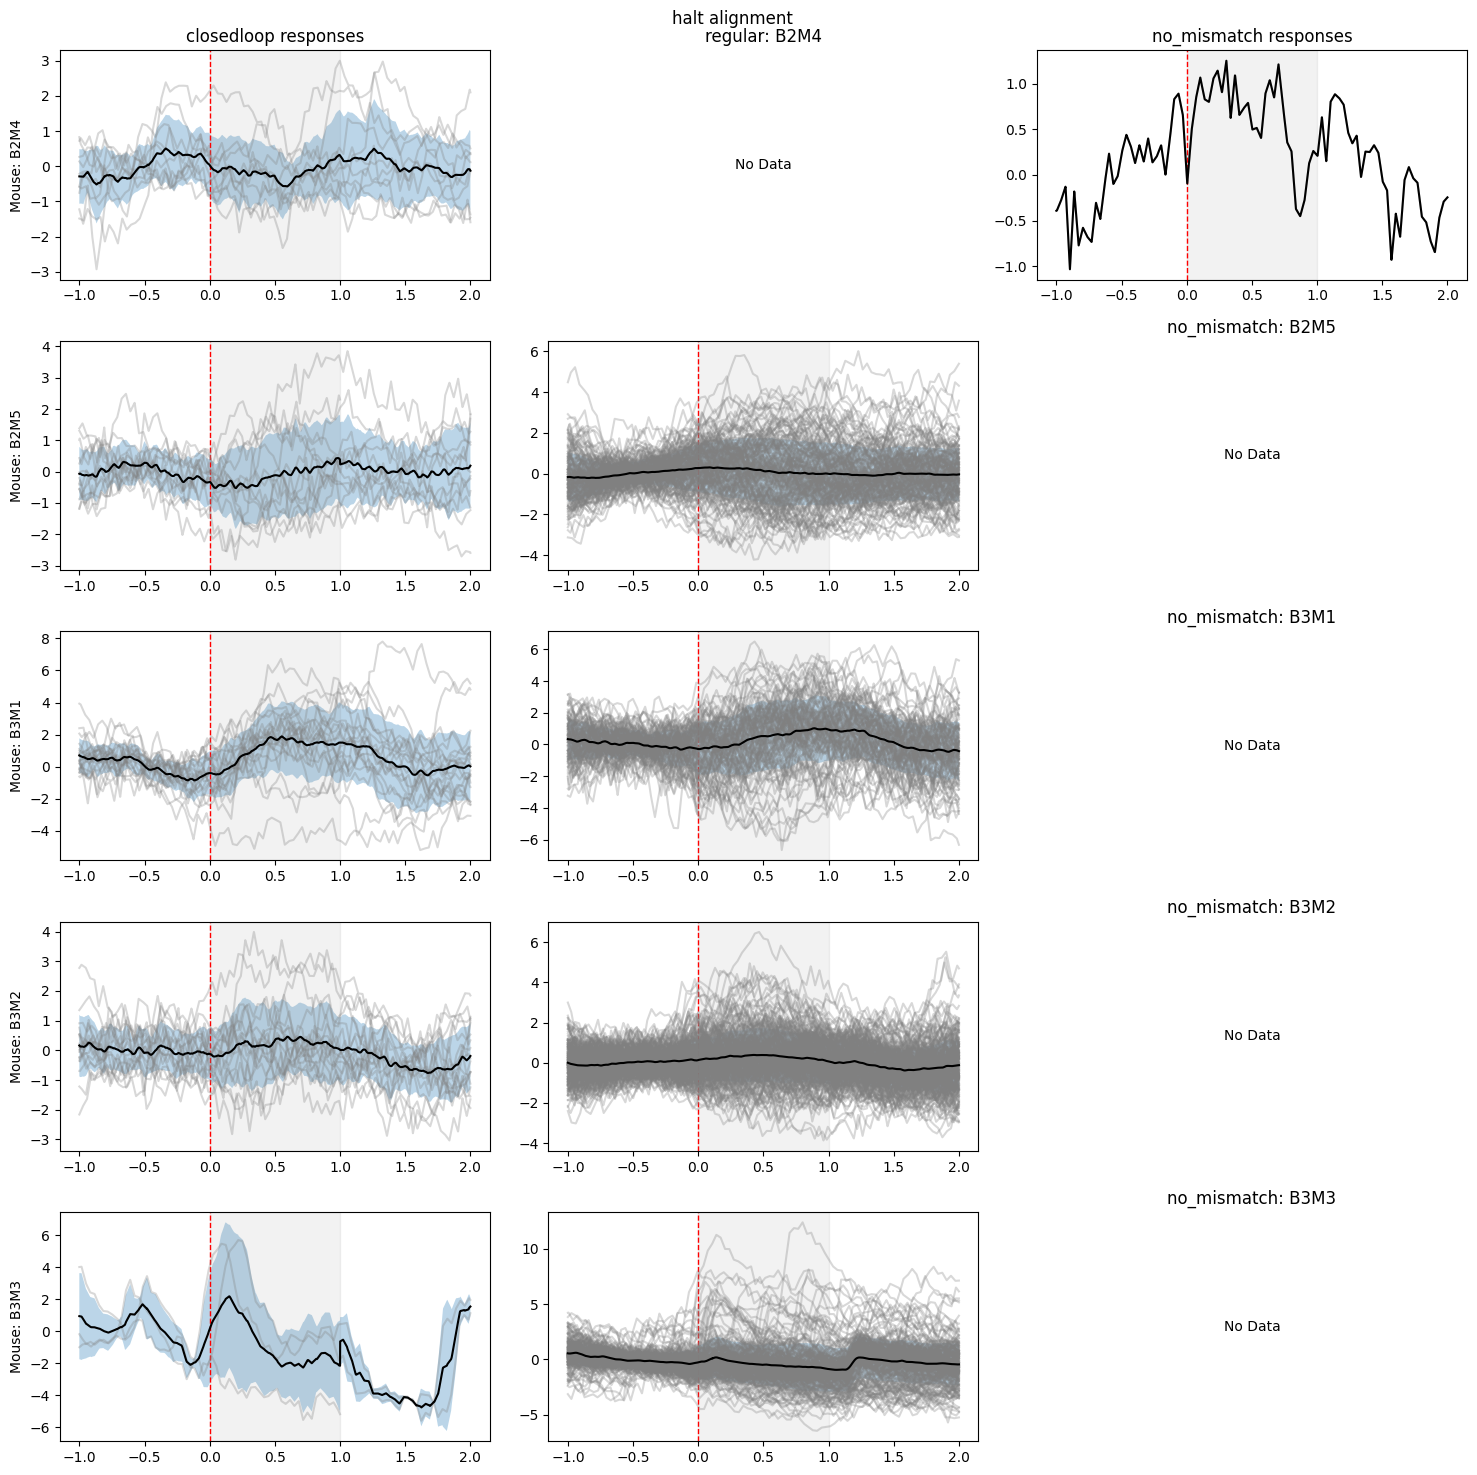

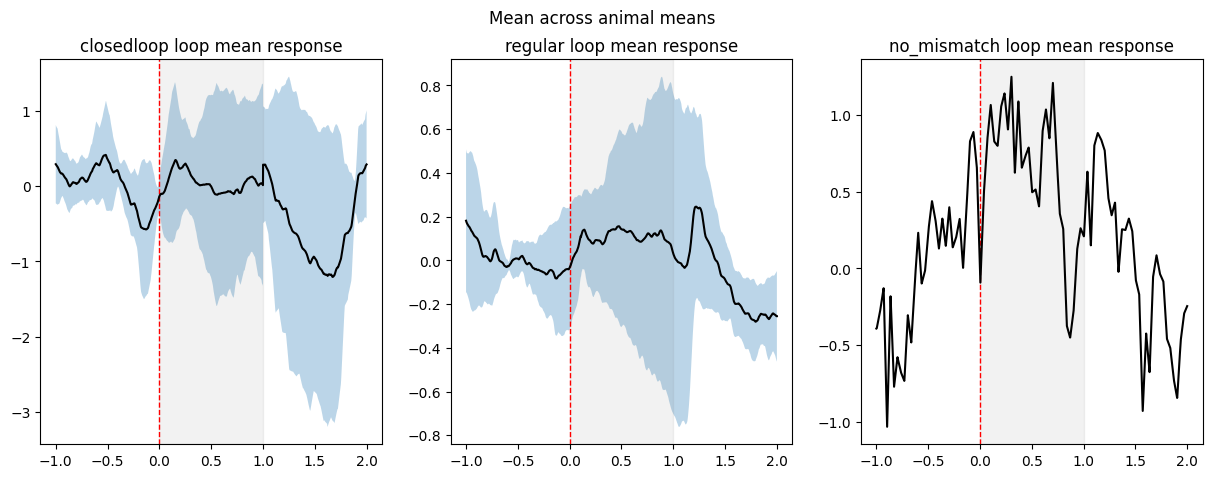

In [125]:
print('\033[1m Session 1 \033[0m')
mean_mouse_dict_s1 =plot_compare_blocks(mouse_aligned['session 1'], 'halt')


 Session 2 


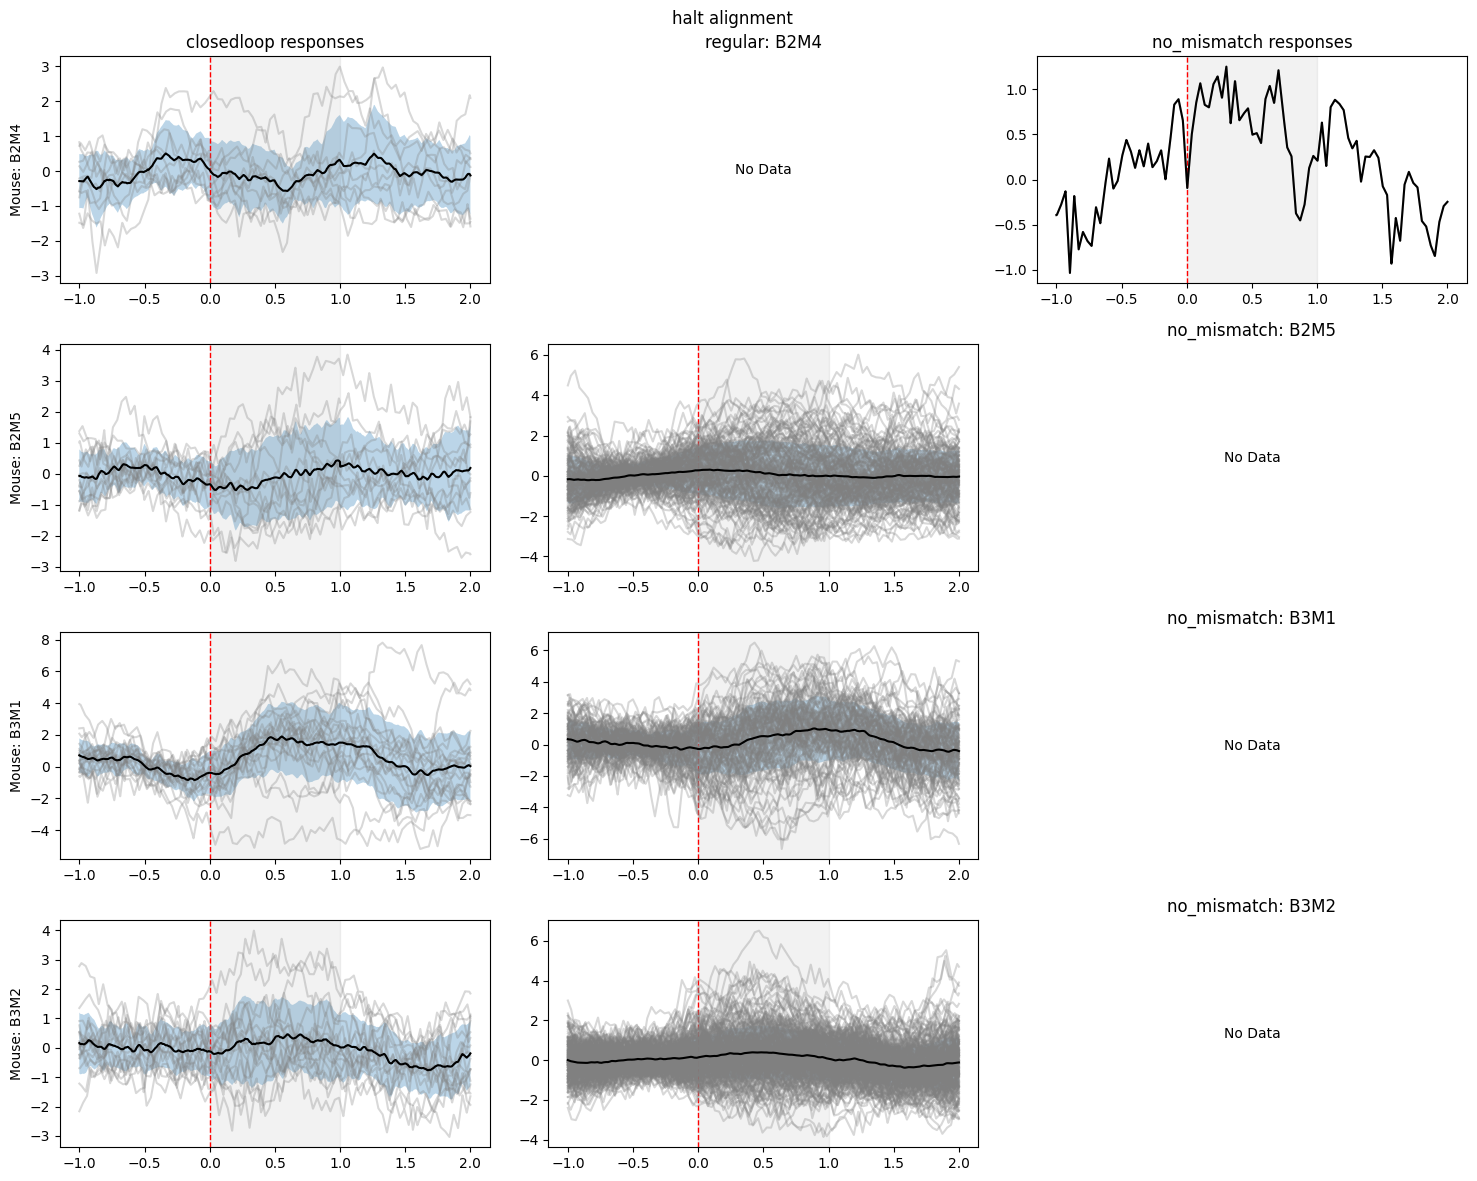

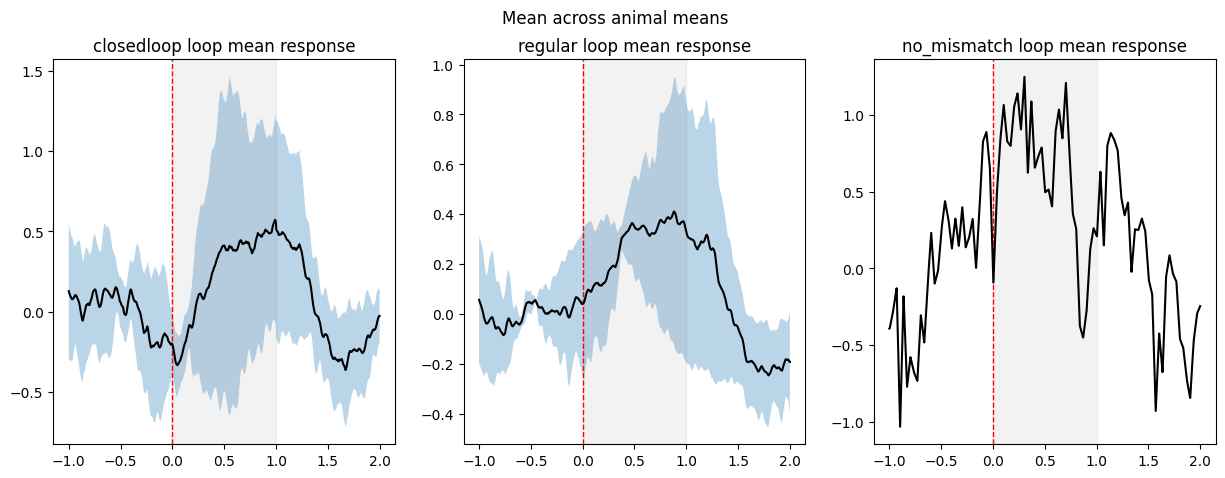

In [126]:
print('\033[1m Session 2 \033[0m')
mean_mouse_dict_s2 =plot_compare_blocks(mouse_aligned['session 2'], 'halt')

 Session 1 no-halt alignment 


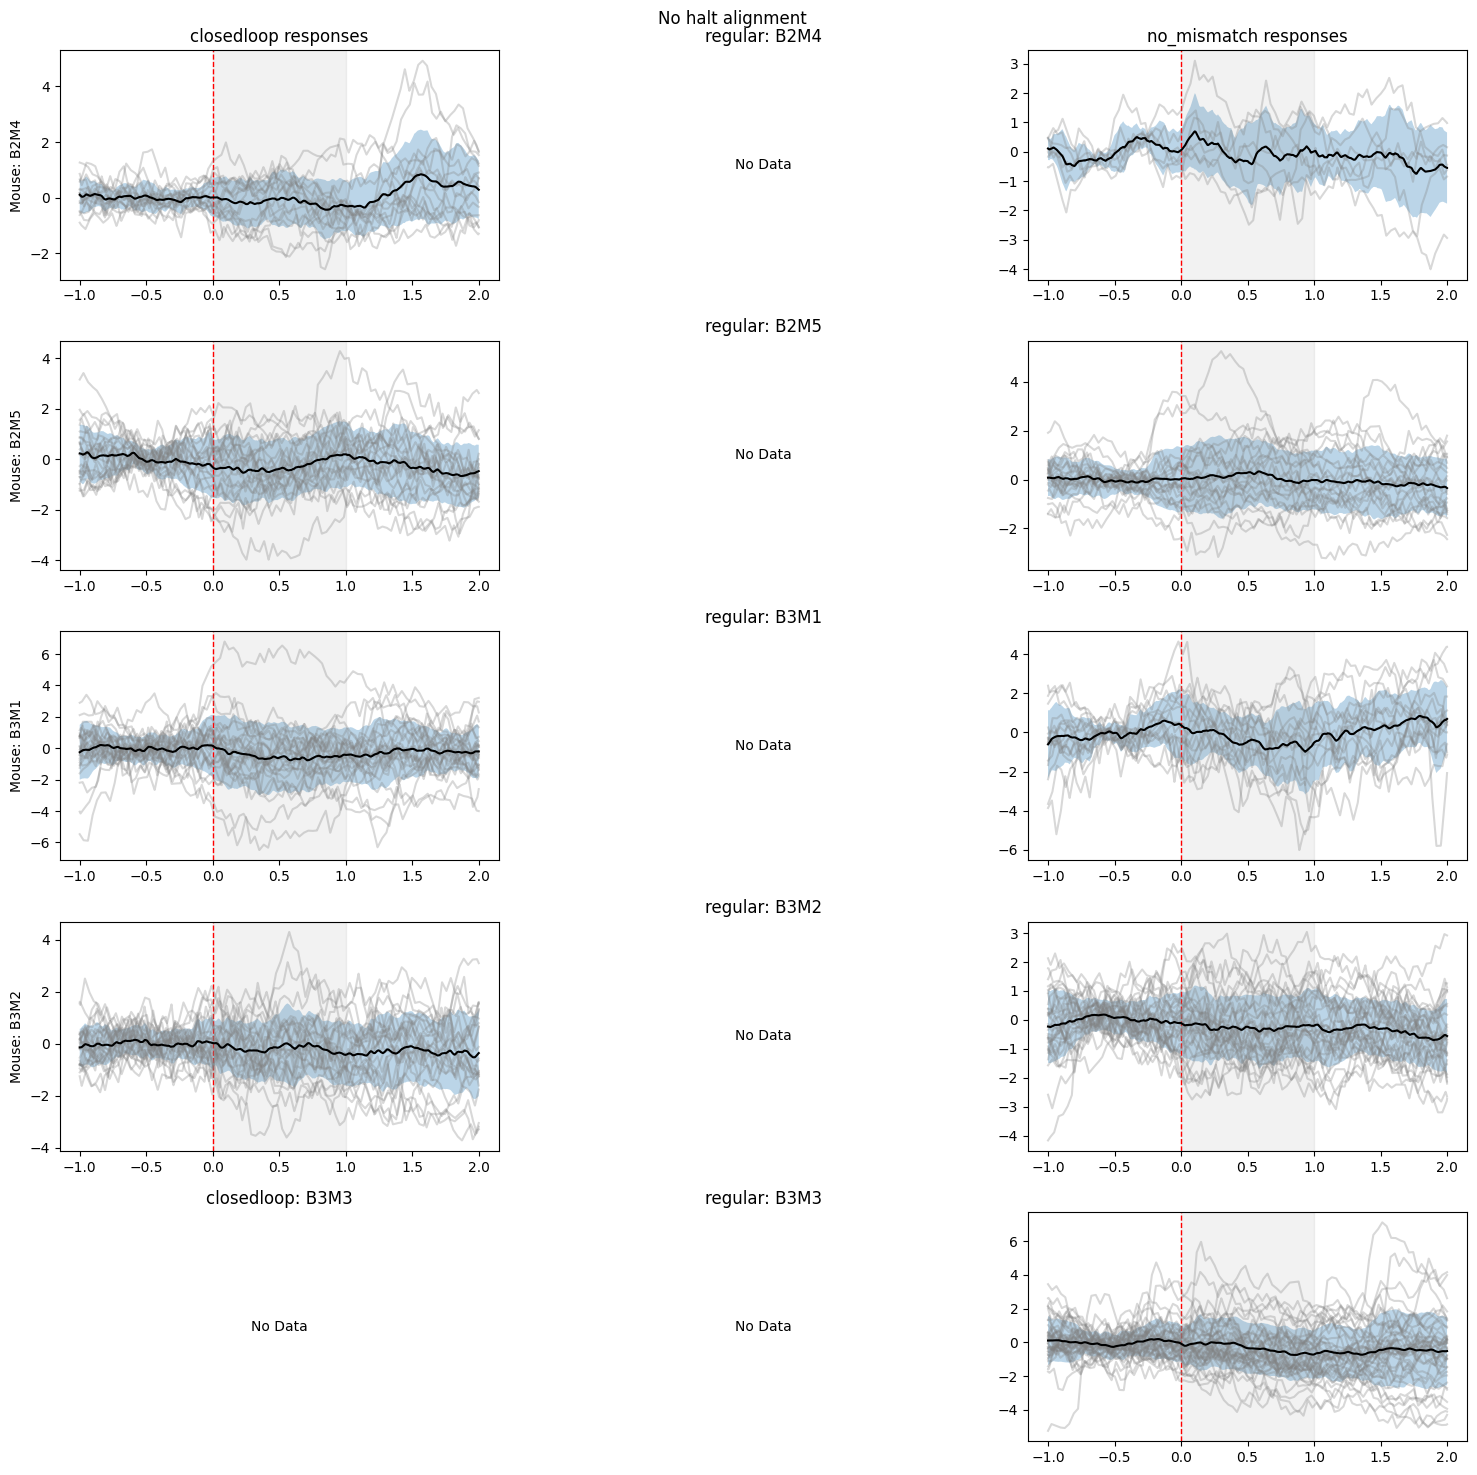

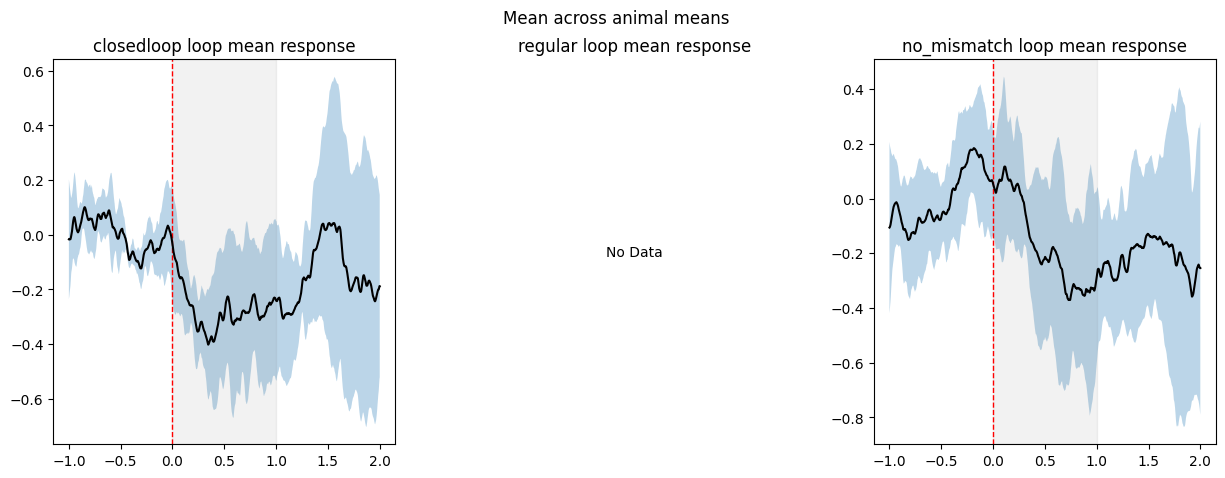

In [127]:
print('\033[1m Session 1 no-halt alignment \033[0m')
mean_mouse_dict_s1_nohalt =plot_compare_blocks(mouse_aligned_nohalt['session 1'], 'No halt')

In [128]:
mouse_aligned['session 1']['closedloop']
mouse_aligned['session 1']['regular']['B2M4']

Empty DataFrame
Columns: []
Index: []

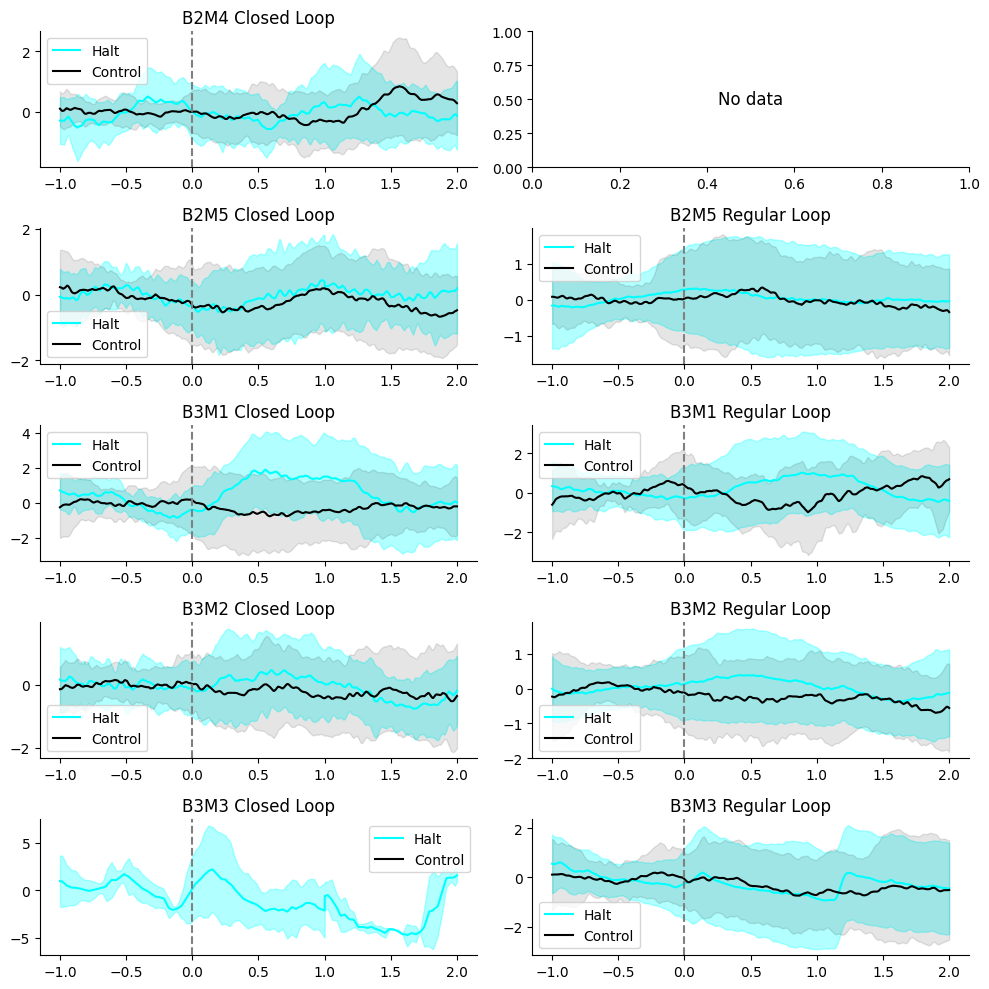

In [131]:
fig, axes = plt.subplots(len(mouse_aligned['session 1']['closedloop']), 2, figsize=(10, 10))
axes = axes.flatten()

i = 0
for (mouse, aligned_data_closed), (mouse_regular, aligned_data_regular) in zip(
    mouse_aligned['session 1']['closedloop'].items(),
    mouse_aligned['session 1']['regular'].items(),
):
    # Closed-loop plot
    ax = axes[i]
    ax.spines[['right', 'top']].set_visible(False)
    
    if not aligned_data_closed.empty:  # Check if closed-loop data is available
        try:
            aligned_nohalt = mouse_aligned_nohalt['session 1']['closedloop'][mouse]

            # Compute mean and standard deviation
            mouse_data_mean = aligned_data_closed.mean(axis=1)
            mouse_data_std = aligned_data_closed.std(axis=1)
            mouse_nohalt_mean = aligned_nohalt.mean(axis=1)
            mouse_nohalt_std = aligned_nohalt.std(axis=1)

            # Plot main trace
            ax.plot(mouse_data_mean, label='Halt', color='cyan')
            ax.fill_between(
                mouse_data_mean.index,
                mouse_data_mean + mouse_data_std,
                mouse_data_mean - mouse_data_std,
                color='cyan',
                alpha=0.3,
            )

            # Plot control trace
            ax.plot(mouse_nohalt_mean, color='black', label='Control')
            ax.fill_between(
                mouse_nohalt_mean.index,
                mouse_nohalt_mean + mouse_nohalt_std,
                mouse_nohalt_mean - mouse_nohalt_std,
                color='black',
                alpha=0.1,
            )

            ax.axvline(0, color='grey', linestyle='--')
            ax.set_title(f'{mouse} Closed Loop')
            ax.legend()
        except KeyError:
            ax.text(0.5, 0.5, 'No data', fontsize=12, ha='center', va='center')
    else:
        ax.text(0.5, 0.5, 'No data', fontsize=12, ha='center', va='center')
    
    i += 1

    # Regular mismatch plot
    ax = axes[i]
    ax.spines[['right', 'top']].set_visible(False)
    
    if not aligned_data_regular.empty:  # Check if regular mismatch data is available
        try:
            aligned_nohalt_reg = mouse_aligned_nohalt['session 1']['no_mismatch'][mouse]

            # Compute mean and standard deviation
            mouse_data_mean = aligned_data_regular.mean(axis=1)
            mouse_data_std = aligned_data_regular.std(axis=1)
            mouse_nohalt_reg_mean = aligned_nohalt_reg.mean(axis=1)
            mouse_nohalt_reg_std = aligned_nohalt_reg.std(axis=1)

            # Plot main trace
            ax.plot(mouse_data_mean, label='Halt', color='cyan')
            ax.fill_between(
                mouse_data_mean.index,
                mouse_data_mean + mouse_data_std,
                mouse_data_mean - mouse_data_std,
                color='cyan',
                alpha=0.3,
            )

            # Plot control trace
            ax.plot(mouse_nohalt_reg_mean, color='black', label='Control')
            ax.fill_between(
                mouse_nohalt_reg_mean.index,
                mouse_nohalt_reg_mean + mouse_nohalt_reg_std,
                mouse_nohalt_reg_mean - mouse_nohalt_reg_std,
                color='black',
                alpha=0.1,
            )

            ax.axvline(0, color='grey', linestyle='--')
            ax.set_title(f'{mouse} Regular Loop')
            ax.legend()
        except KeyError:
            ax.text(0.5, 0.5, 'No data', fontsize=12, ha='center', va='center')
    else:
        ax.text(0.5, 0.5, 'No data', fontsize=12, ha='center', va='center')
    
    i += 1

fig.tight_layout(pad=1.08)



In [169]:
def plot_mouse_blocks(session_blocks, control_blocks, title="Mouse Blocks"):
    """
    Create a figure for each mouse with the blocks plotted side by side.
    
    Parameters:
    - session_blocks (dict): A dictionary where keys are block names (e.g., 'closedloop') 
                             and values are dictionaries of mouse data.
    - control_blocks (dict): A dictionary with the same structure as `session_blocks` 
                             but for control data.
    - title (str): Title prefix for each mouse figure.
    """
    for block_name, session_data in session_blocks.items():
        for mouse, main_data in session_data.items():
            # Create a new figure for each mouse
            fig, axes = plt.subplots(1, len(session_blocks), figsize=(5 * len(session_blocks), 4), squeeze=False)
            fig.suptitle(f"{title}: {mouse}")

            for i, (block, mouse_data) in enumerate(session_blocks.items()):
                ax = axes[0, i]
                ax.spines[['right', 'top']].set_visible(False)

                if mouse not in mouse_data or mouse_data[mouse].empty:
                    ax.text(0.5, 0.5, 'No data', fontsize=12, ha='center', va='center')
                    ax.set_title(f"No data for {mouse} - {block}")
                else:
                    # Compute mean and std for the main trace
                    main_mean = mouse_data[mouse].mean(axis=1)
                    main_std = mouse_data[mouse].std(axis=1)

                    # Plot the main trace
                    ax.plot(main_mean, label='Halt', color='cyan')
                    ax.fill_between(
                        main_mean.index,
                        main_mean - main_std,
                        main_mean + main_std,
                        color='cyan',
                        alpha=0.3,
                    )

                    # Add control trace if available
                    if block in control_blocks and mouse in control_blocks[block]:
                        control_data = control_blocks[block][mouse]
                        control_mean = control_data.mean(axis=1)
                        control_std = control_data.std(axis=1)

                        ax.plot(control_mean, label='Control', color='black')
                        ax.fill_between(
                            control_mean.index,
                            control_mean - control_std,
                            control_mean + control_std,
                            color='black',
                            alpha=0.1,
                        )

                    ax.axvline(0, color='grey', linestyle='--')
                    ax.set_title(f"{block} Block")
                    ax.legend()

            plt.tight_layout()
            plt.show()

In [170]:
def plot_mean_across_blocks(session_blocks, control_blocks, title="Mean Across Blocks"):
    """
    Plot a single figure with the mean across mouse means for each block.
    
    Parameters:
    - session_blocks (dict): Dictionary of session data, where keys are block names
                             and values are dictionaries of mouse data.
    - control_blocks (dict): Dictionary of control data with the same structure.
    - title (str): Title of the plot.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.spines[['right', 'top']].set_visible(False)

    for block_name, mouse_data in session_blocks.items():
        if not mouse_data:
            print(f"No data for block: {block_name}")
            continue

        # Compute mean and std across all mice
        block_means = [data.mean(axis=1) for data in mouse_data.values()]
        mean_across_mice = pd.concat(block_means, axis=1).mean(axis=1)
        std_across_mice = pd.concat(block_means, axis=1).std(axis=1)

        # Plot block trace
        ax.plot(mean_across_mice, label=f'{block_name} Mean')
        ax.fill_between(
            mean_across_mice.index,
            mean_across_mice - std_across_mice,
            mean_across_mice + std_across_mice,
            alpha=0.2,
        )

    # Plot control trace
    if control_blocks:
        control_means = [
            data.mean(axis=1) for block_data in control_blocks.values()
            for data in block_data.values()
        ]
        control_mean = pd.concat(control_means, axis=1).mean(axis=1)
        control_std = pd.concat(control_means, axis=1).std(axis=1)

        ax.plot(control_mean, label="Control Mean", color='black', linestyle='--')
        ax.fill_between(
            control_mean.index,
            control_mean - control_std,
            control_mean + control_std,
            color='grey',
            alpha=0.3,
        )

    ax.axvline(0, color='grey', linestyle='--')
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

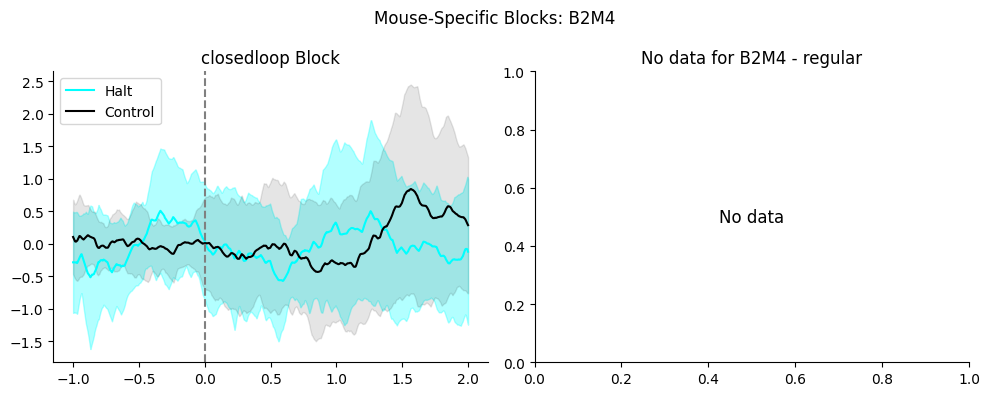

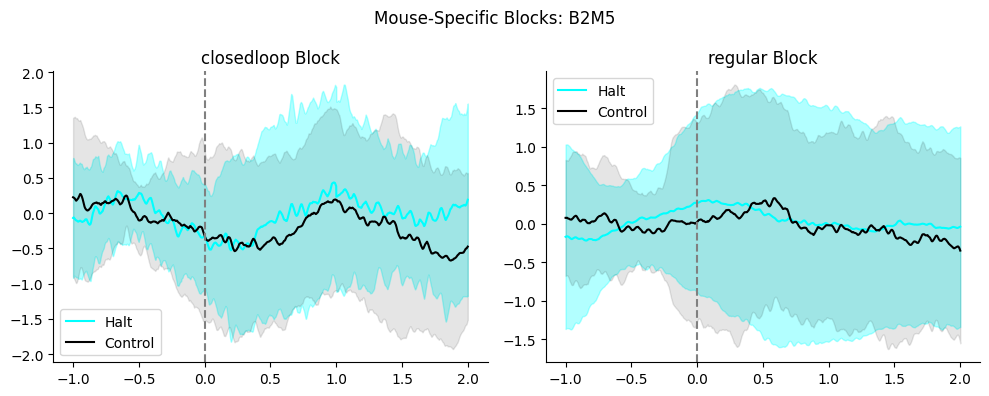

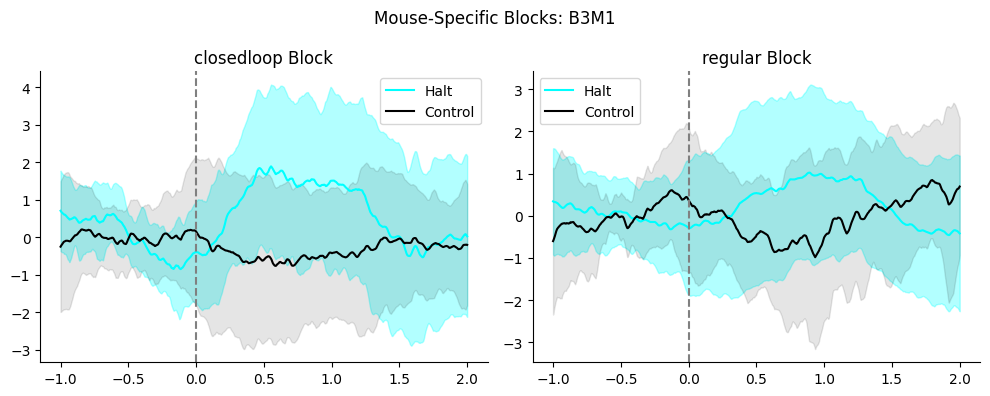

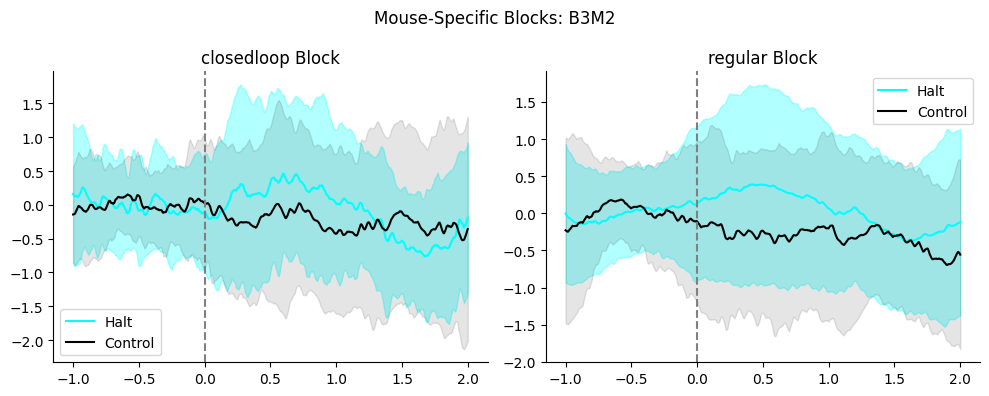

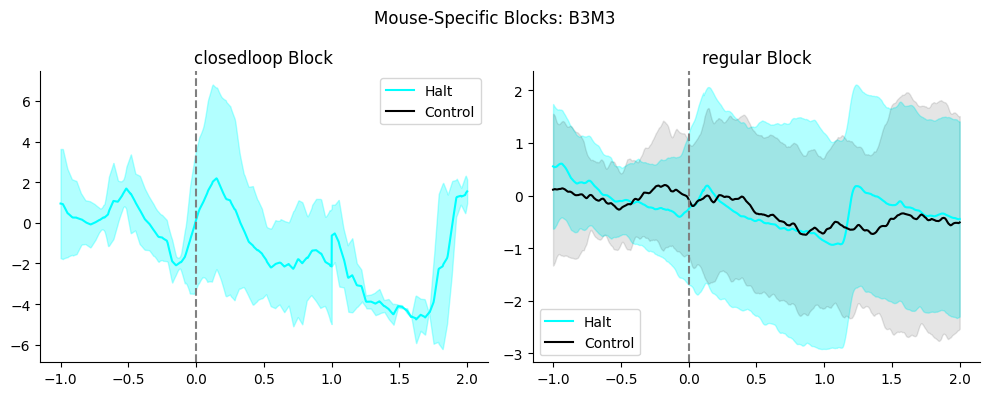

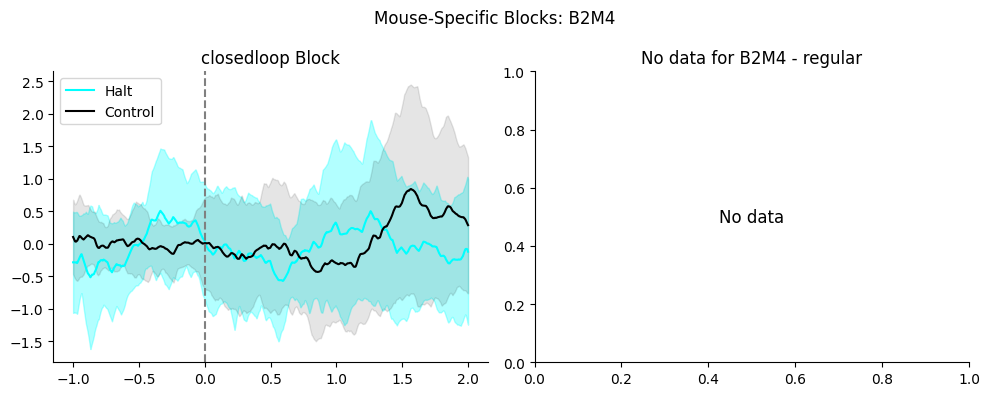

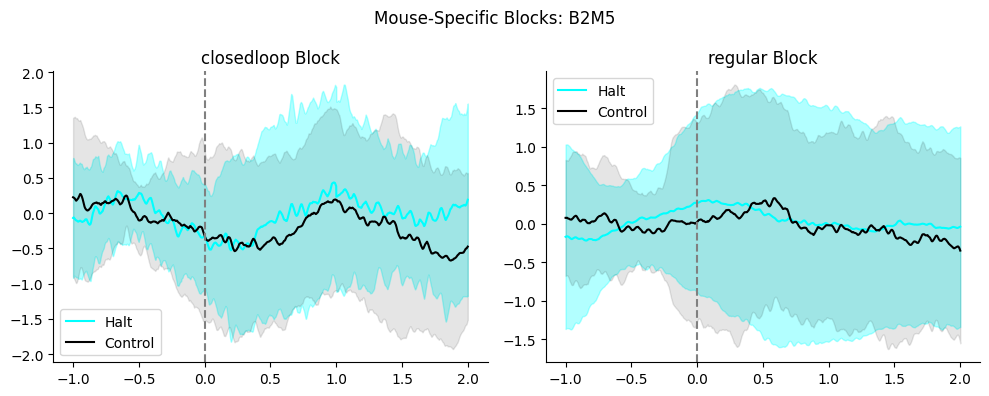

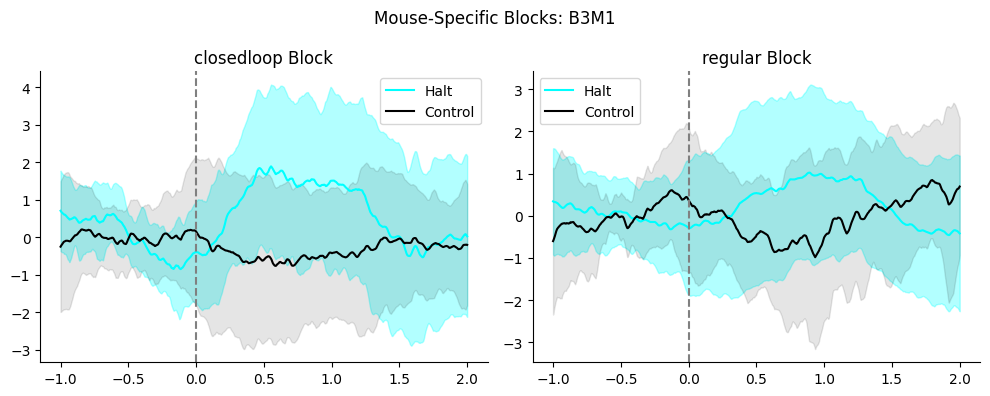

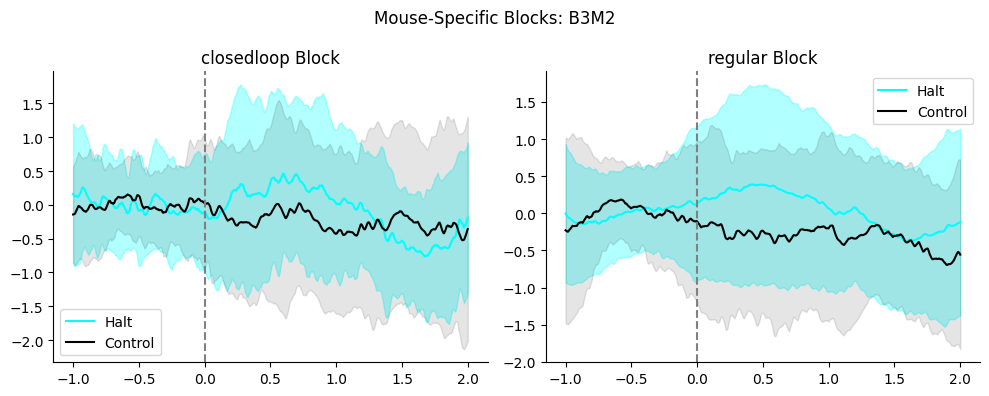

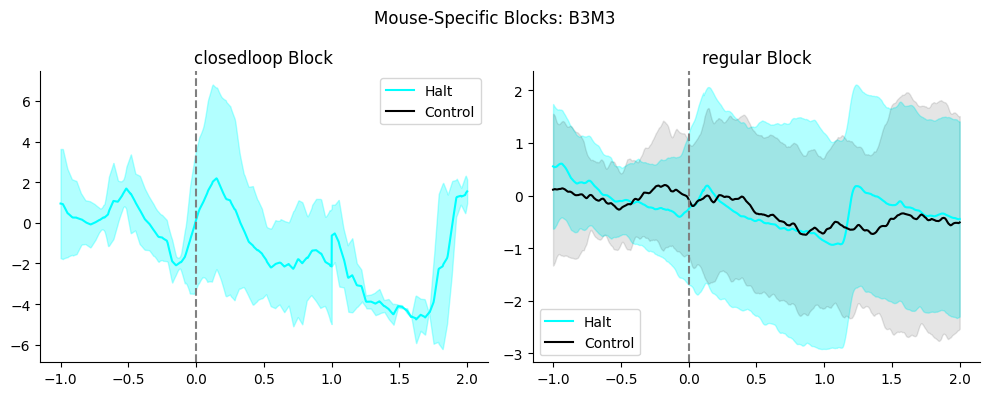

In [171]:
session_blocks = {
    'closedloop': mouse_aligned['session 1']['closedloop'],
    'regular': mouse_aligned['session 1']['regular'],
}

control_blocks = {
    'closedloop': mouse_aligned_nohalt['session 1']['closedloop'],
    'regular': mouse_aligned_nohalt['session 1']['no_mismatch'],
}

plot_mouse_blocks(session_blocks, control_blocks, title="Mouse-Specific Blocks")



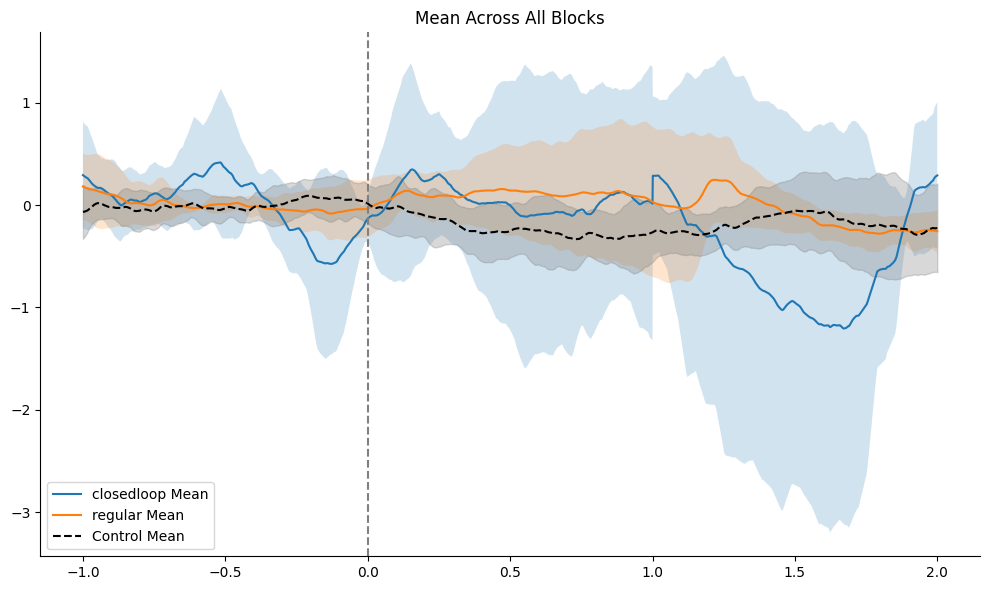

In [172]:
plot_mean_across_blocks(session_blocks, control_blocks, title="Mean Across All Blocks")



In [135]:
def extract_aligned_vars(aligned_data_dict, aligned_movement_dict):
    # Initialize an empty list to store results
    results = []
    
    for session_number, session_blocks in aligned_data_dict.items():
        for session_block, mice_data in session_blocks.items():
            for mouse_id, item in mice_data.items():
                run_df = aligned_movement_dict[session_number][session_block][mouse_id]
                # Check if the item is a DataFrame
                if not isinstance(item, pd.DataFrame):
                    print(f"Warning: The data for Mouse ID '{mouse_id}' in session '{session_number}' and block '{session_block}' is not a DataFrame. Skipping.")
                    continue

                # Copy the DataFrame and ensure the index is numeric
                df = item.copy()
                df.index = pd.to_numeric(df.index)

                # Process each column independently
                for column in df.columns:
                    event_time_data = df.loc[0:1, column]  # Data during the event (0 to +1 seconds)
                    post_event_data = df.loc[1:2, column]  # Data during the first second after the event (+1 to +2 seconds)

                    peak_response = event_time_data.max()  # Max response during the event
                    min_response = event_time_data.min()  # Minimum response during the event
                    mean_response_event = event_time_data.mean()  # Mean response during the event
                    mean_response_post_event = post_event_data.mean()  # Mean response during the post-event time
                    min_response_post_event = post_event_data.min()  #Minimum response during the post-event time
                    peak_response_post_event = post_event_data.max() #Maximum response during the post-event time

                    #Given Mean_moveX and Y being the row names in the movement df, the 1 second pre halt movement speeds are added
                    x_move = run_df.loc['Mean_moveX', column]
                    y_move = run_df.loc['Mean_moveY', column]
    
                    #add results to list of dicts
                    results.append({
                        "SessionNumber": session_number,
                        "SessionBlock": session_block,
                        "MouseID": mouse_id,
                        "EventTime": column,
                        "moveX": x_move,
                        "moveY": y_move,
                        "PeakResponse": peak_response,
                        "MinResponse":  min_response,
                        "MeanResponse": mean_response_event,
                        "MeanResponse_after": mean_response_post_event,
                        "MinResponse_after": min_response_post_event,
                        "PeakResponse_after": peak_response_post_event,
                    })

    # convert to a pandas df
    output_df = pd.DataFrame(results)
    return output_df



In [136]:
extracted_variables = extract_aligned_vars(mouse_aligned, move_speeds)


In [137]:
extracted_variables 

SessionNumber SessionBlock MouseID  EventTime     moveX     moveY  \
0        session 1   closedloop    B2M4   1333.001  0.081412  0.008703   
1        session 1   closedloop    B2M4   1343.768  0.096112  0.012077   
2        session 1   closedloop    B2M4   1365.801  0.061120  0.010081   
3        session 1   closedloop    B2M4   1414.684  0.109788  0.008807   
4        session 1   closedloop    B2M4   1433.750  0.059148  0.002783   
...            ...          ...     ...        ...       ...       ...   
1324     session 2      regular    B3M2   1265.472  0.142224  0.006871   
1325     session 2      regular    B3M2   1267.955  0.144005  0.010890   
1326     session 2      regular    B3M2   1270.455  0.130761  0.012767   
1327     session 2      regular    B3M2   1272.955  0.132684  0.007849   
1328     session 2  no_mismatch    B2M4     86.879  0.083796  0.010898   

      PeakResponse  MinResponse  MeanResponse  MeanResponse_after  \
0         1.195356    -0.256045      0.396702            0.838395   
1        -0.028073    -1.280589     -0.697178           -0.064497   
2        -0.530046    -2.321845     -1.180927           -0.661983   
3         0.702351    -0.538133      0.157456           -0.734807   
4         0.101872    -1.360960     -0.536636           -1.287751   
...            ...          ...           ...                 ...   
1324      0.242408    -0.952862     -0.375718            0.175138   
1325      0.659845    -1.116955     -0.279598           -0.751723   
1326      1.858580    -0.349883      0.441304            0.138250   
1327      2.736490     0.957738      1.803583            0.705988   
1328      1.250278    -0.451345      0.611336            0.023595   

      MinResponse_after  PeakResponse_after  
0              0.324907            1.350261  
1             -0.623926            0.584640  
2             -1.857020            0.147783  
3             -1.466414            0.166567  
4             -1.612481           -0.643230  
...                 ...                 ...  
1324          -1.447836            1.201134  
1325          -1.522923           -0.164377  
1326          -2.037850            1.850797  
1327           0.147425            1.654395  
1328          -0.930134            0.883218  

[1329 rows x 12 columns]

In [138]:
extracted_variables_nohalt = extract_aligned_vars(mouse_aligned_nohalt, move_speeds_nohalt)


In [139]:
extracted_variables_nohalt['event']='no halt'
extracted_variables['event']='halt'
combined_vars = pd.concat([extracted_variables_nohalt, extracted_variables])

combined_vars.to_csv('GRAB_MM_extracted_vars.csv', index=False)

In [140]:
##Consider adding to the fitted model a continous variable which is the time column
#EventTime should currently be seconds from session start

# Look for correlation between running and fluorescence changes

In [141]:
GCaMP_Reg_1

470_dfF     movementX  movementY   halt ExperimentEvents  \
Seconds                                                               
0.000    -0.000021  1.411287e-03   0.000578  False              NaN   
0.001    -0.000067  4.547482e-03   0.001861  False              NaN   
0.002    -0.000113  6.272389e-03   0.002336  False              NaN   
0.003    -0.000159  6.272389e-03   0.001823  False              NaN   
0.004    -0.000205  6.272389e-03   0.001309  False              NaN   
...            ...           ...        ...    ...              ...   
1992.723  5.189932  1.729690e-05   0.000000  False              NaN   
1992.724  5.186361  1.255802e-05   0.000000  False              NaN   
1992.725  5.182791  7.819145e-06   0.000000  False              NaN   
1992.726  5.179220  3.080269e-06   0.000000  False              NaN   
1992.727  5.177078  2.369438e-07   0.000000  False              NaN   

                    Experiment Session mouseID sex area  No_halt  \
Seconds                                                            
0.000     MMclosed-and-Regular    day1    B2M4   M  V2M    False   
0.001     MMclosed-and-Regular    day1    B2M4   M  V2M    False   
0.002     MMclosed-and-Regular    day1    B2M4   M  V2M    False   
0.003     MMclosed-and-Regular    day1    B2M4   M  V2M    False   
0.004     MMclosed-and-Regular    day1    B2M4   M  V2M    False   
...                        ...     ...     ...  ..  ...      ...   
1992.723  MMclosed-and-Regular    day1    B3M3   F   V1    False   
1992.724  MMclosed-and-Regular    day1    B3M3   F   V1    False   
1992.725  MMclosed-and-Regular    day1    B3M3   F   V1    False   
1992.726  MMclosed-and-Regular    day1    B3M3   F   V1    False   
1992.727  MMclosed-and-Regular    day1    B3M3   F   V1    False   

          LinearMismatch_block  LinearRegularMismatch_block  \
Seconds                                                       
0.000                    False                        False   
0.001                    False                        False   
0.002                    False                        False   
0.003                    False                        False   
0.004                    False                        False   
...                        ...                          ...   
1992.723                 False                        False   
1992.724                 False                        False   
1992.725                 False                        False   
1992.726                 False                        False   
1992.727                 False                        False   

          LinearNormal_block  
Seconds                       
0.000                  False  
0.001                  False  
0.002                  False  
0.003                  False  
0.004                  False  
...                      ...  
1992.723               False  
1992.724               False  
1992.725               False  
1992.726               False  
1992.727               False  

[9861055 rows x 14 columns]

In [160]:
subset = filter_data(GCaMP_Reg_1, ['B2M5', 'day1'])

In [161]:
subset

470_dfF  movementX  movementY   halt ExperimentEvents  \
Seconds                                                            
0.000    -0.000002   0.007717   0.000996  False              NaN   
0.001    -0.000005   0.024866   0.003209  False              NaN   
0.002    -0.000009   0.042014   0.005422  False              NaN   
0.003    -0.000012   0.059163   0.007635  False              NaN   
0.004    -0.000016   0.076311   0.009848  False              NaN   
...            ...        ...        ...    ...              ...   
2010.197 -0.566807   0.000124   0.000025  False              NaN   
2010.198 -0.565726   0.000093   0.000019  False              NaN   
2010.199 -0.564645   0.000061   0.000012  False              NaN   
2010.200 -0.563565   0.000030   0.000006  False              NaN   
2010.201 -0.562754   0.000006   0.000001  False              NaN   

                    Experiment Session mouseID sex area  No_halt  \
Seconds                                                            
0.000     MMclosed-and-Regular    day1    B2M5   M  V2M    False   
0.001     MMclosed-and-Regular    day1    B2M5   M  V2M    False   
0.002     MMclosed-and-Regular    day1    B2M5   M  V2M    False   
0.003     MMclosed-and-Regular    day1    B2M5   M  V2M    False   
0.004     MMclosed-and-Regular    day1    B2M5   M  V2M    False   
...                        ...     ...     ...  ..  ...      ...   
2010.197  MMclosed-and-Regular    day1    B2M5   M  V2M    False   
2010.198  MMclosed-and-Regular    day1    B2M5   M  V2M    False   
2010.199  MMclosed-and-Regular    day1    B2M5   M  V2M    False   
2010.200  MMclosed-and-Regular    day1    B2M5   M  V2M    False   
2010.201  MMclosed-and-Regular    day1    B2M5   M  V2M    False   

          LinearMismatch_block  LinearRegularMismatch_block  \
Seconds                                                       
0.000                    False                        False   
0.001                    False                        False   
0.002                    False                        False   
0.003                    False                        False   
0.004                    False                        False   
...                        ...                          ...   
2010.197                 False                        False   
2010.198                 False                        False   
2010.199                 False                        False   
2010.200                 False                        False   
2010.201                 False                        False   

          LinearNormal_block  
Seconds                       
0.000                  False  
0.001                  False  
0.002                  False  
0.003                  False  
0.004                  False  
...                      ...  
2010.197               False  
2010.198               False  
2010.199               False  
2010.200               False  
2010.201               False  

[2010202 rows x 14 columns]

In [162]:
# Compute Pearson correlation
pearson_corr, pearson_pval = pearsonr(subset['movementX'], subset['470_dfF'])

# Compute Spearman correlation (handles nonlinear relationships better)
spearman_corr, spearman_pval = spearmanr(subset['movementX'], subset['470_dfF'])

print(f"Pearson correlation: {pearson_corr}, p-value: {pearson_pval}")
print(f"Spearman correlation: {spearman_corr}, p-value: {spearman_pval}")

Pearson correlation: -0.07093130211407388, p-value: 0.0
Spearman correlation: -0.06165789003171408, p-value: 0.0


In [163]:
resampled = subset.sample(10000, random_state=9)  # Sample 10,000 rows
pearson_corr, pearson_pval = pearsonr(resampled['movementX'], resampled['470_dfF'])
spearman_corr, spearman_pval = spearmanr(resampled['movementX'], resampled['470_dfF'])
print(f"Subset Pearson correlation: {pearson_corr}, p-value: {pearson_pval}")
print(f"Subset Spearman correlation: {spearman_corr}, p-value: {spearman_pval}")

Subset Pearson correlation: -0.08114653943735207, p-value: 4.3988533329590867e-16
Subset Spearman correlation: -0.0740245215366139, p-value: 1.2469387224855925e-13


In [30]:
import numpy as np
from scipy.stats import bootstrap

#data = np.array([GCaMP_Reg_1['movementX'], GCaMP_Reg_1['470_dfF']]).T
#ci = bootstrap((data,), np.corrcoef, confidence_level=0.95, n_resamples=1000)
#print(f"95% Confidence Interval for Pearson correlation: {ci.confidence_interval}")
